# Simple Rule Based Scanner

This workshop shop is a training exercise in data scanning system by writing Python code.

### Objectives:
1. Practice writing rule-based conditions as needed for data scanning
2. Explore scanned data to view details
3. Practice setting up and running REST APIs for use in the scanning system

### Applications:
Data scanning systems can be used in a variety of cases, such as:
1. Finding stocks or products that are worth investing in
2. Filtering signals or product behavior
3. Exploring the overall market situation

In [1]:
import os
import math
import pandas as pd
import numpy as np
import pandas_ta as pdta
import matplotlib.pyplot as plt
import mplfinance as mpf


def data_range(df_dataset, from_date='', to_date='', window=100):
    dt_col = 'DATETIME' if 'DATETIME' in df_dataset else 'datetime'
    
    if from_date == '' and to_date == '':
        df_dataset = df_dataset.iloc[df_dataset.shape[0]-window:df_dataset.shape[0], :].copy()
    else:
        if from_date is not None and from_date != '' and to_date is not None and to_date != '':
            from_date = '{}000000'.format(from_date.replace('-', ''))
            to_date = '{}235500'.format(to_date.replace('-', ''))

            df_dataset = df_dataset.loc[(df_dataset[dt_col].astype(str) >= from_date) \
                                            & (df_dataset[dt_col].astype(str) <= to_date)]
            df_dataset = df_dataset.reset_index(drop=True)

    return df_dataset

def build_ohlc_df(df_master):
    df = pd.DataFrame()
    df['DATETIME'] = df_master['DATETIME']
    df['Open'] = df_master['OPEN']
    df['High'] = df_master['HIGH']
    df['Low'] = df_master['LOW']
    df['Close'] = df_master['CLOSE']
    return df


def plot_df(data, col, title, x_label, y_label, plot_label, data_x=None, data_y=None
            , chart_width=20, chart_height=8
            , fontsize_axis=14, fontsize_title=20, fontsize_legend=1
            , legend_position='upper right'):
    plt.figure(figsize=(chart_width, chart_height))
    if data is not None:
        x = np.arange(data.shape[0])
        y = data[col]
    else:
        x = data_x
        y = data_y
    plt.plot(x, y, label=plot_label)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.title(title, fontsize=20)
    plt.legend(loc='upper right', fontsize=1)
    plt.show()

def plot_ohlc(data, type='candle', style='charles', title='Signals'
             , ylabel='Prices', figratio=(20, 8)
             , addplot=None,):
    if addplot is None:
        mpf.plot(data, type=type, style=style, title=title
                 , ylabel=ylabel, figratio=figratio
                 , **{'warn_too_much_data':data.shape[0] + 1}
                 ,)
    else:
        mpf.plot(data, type=type, style=style, title=title
                 , ylabel=ylabel, figratio=figratio, addplot=addplot
                 , **{'warn_too_much_data':data.shape[0] + 1}
                 ,)
        
def plot_ohlc_sig(data_ohlc, data_sig, markersize=100
                  , buy_pos=0.999, sell_pos=1.001
                  , c_width=30, c_height=8):

    sig_open_buy = np.where(data_sig['SIGNAL'] == 1, 1, 0)
    sig_open_sell = np.where(data_sig['SIGNAL'] == 11, 11, 0)

    sig_buy_arrow_pos = np.where(sig_open_buy > 0, 1, np.nan) * buy_pos * data_ohlc['Low']
    sig_sell_arrow_pos = np.where(sig_open_sell > 0, 1, np.nan) * sell_pos * data_ohlc['High']

    arrows = []
    if 1 in sig_open_buy:
        arrows.append(mpf.make_addplot(sig_buy_arrow_pos, scatter=True, markersize=markersize, marker=r'$\Uparrow$', color='green'))
    if 11 in sig_open_sell:
        arrows.append(mpf.make_addplot(sig_sell_arrow_pos, scatter=True, markersize=markersize, marker=r'$\Downarrow$', color='red'))
    
    plot_ohlc(data_ohlc
                , type='candle' # type='line'
                , style='charles'
                , title='Signals'
                , ylabel='Prices'
                , figratio=(c_width, c_height)
                , addplot=arrows
                ,)

## FELib class

FELib is a utility code for helping with feature engineering. The full code is in the deepquant.common.felib.py package and has several functions for feature engineering. It can also be extended as a class to further develop it.

In [2]:
class FELib:
    """
    Simple Feature Engineering Library
    """

    @staticmethod
    def iif(condition, resultTrue, resultFalse):
        return np.where(condition, resultTrue, resultFalse)

    @staticmethod
    def llv(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).min()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def hhv(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            # series = series.fillna(0)
            result = series.rolling(period, min_periods=1).max()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def ma(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).mean()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def stdev(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).std(skipna=True)
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

## Base Class of Simple Rule Based Scanner

The scanner's super class is a class that the user needs to create a child class for and extend. The user then needs to implement two functions of their own called add_indi() and eval_condition(). These functions will be used in the scanner.

In [3]:
class BaseScanner:
    
    def __init__(self, symbols):
        self.symbols = symbols

    @staticmethod
    def load_data(dataset_path='../datasets/SET'
                    , columns_master=['DATETIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']
                    , datetime_format='%Y%m%d'):
        symbols = {} # key is symbol name, value is dataframe  
        
        with os.scandir(dataset_path) as entries:
            for entry in entries:
                if '.csv' in entry.name:
                    data_symbol = pd.read_csv(f"{dataset_path}/{entry.name}")

                    if 'Ticker' in data_symbol.columns:
                        data_symbol.drop(['Ticker'], axis=1, inplace=True)

                    if data_symbol.columns[-1].upper() != 'VOLUME':
                        columns_master.remove('VOLUME')

                    data_symbol.columns = columns_master
                    data_symbol['DATETIME'] = pd.to_datetime(data_symbol['DATETIME'])
                    symbols[entry.name.replace('.csv', '')] = data_symbol
        
        return symbols

    def add_indi(self):
        def create_indi(symbol_name, dataset):
            """
            Sample code:

            dataset['MA1'] = pdta.sma(dataset['CLOSE'], 10)
            dataset['MA2'] = pdta.wma(dataset['CLOSE'], 50)
            dataset['MA3'] = pdta.ema(dataset['CLOSE'], 200)
            dataset['RSI_S'] = pdta.rsi(dataset['CLOSE'], 10)
            dataset['RSI_M'] = pdta.ema( pdta.rsi(dataset['CLOSE'], 28), 10 )
            df_macd_s = pdta.macd(dataset['CLOSE'], 12, 26, 9)
            dataset['MACD_S'] = df_macd_s.iloc[:, 0]
            dataset['MACD_HIST_S'] = df_macd_s.iloc[:, 1]
            dataset['MACD_SIGNAL_S'] = df_macd_s.iloc[:, 2]
            """
            
            dataset.fillna(0.0, inplace=True) # fill ค่า NaN ด้วยค่า 0.0
    
        #==============================================================================
        for symbol_name in self.symbols.keys():
            create_indi(symbol_name, self.symbols[symbol_name])
    
    def eval_condition(self, symbol_name, dataset):
        result = False
        predict_result = None
        """
        Sample code:
        
        predict_result = np.where((dataset.MA1 > dataset.MA2)
                                 , 1, 0)
        """
        if predict_result[-1] == 1:
            result = True

        return result

    def scan(self, info=False):
        if len(self.symbols) == 0:
            raise Exception('symbols has not been initialized')
        
        scan_results = []

        for symbol_name in symbols.keys():
            result = self.eval_condition(symbol_name, symbols[symbol_name])
            scan_results.append({'SYMBOL': symbol_name, 'SCAN_RESULT': result})
            
        if info == True:
            first_df = list(self.symbols.values())[0]
            all_columns = first_df.columns
            last_col_index = 0
            if 'VOLUME' in all_columns:
                last_col_index = list(all_columns).index('VOLUME')
            else:
                last_col_index = list(all_columns).index('CLOSE')
            
            # convert scanned results to dataframe
            symbol_columns = ['SYMBOL', 'SCAN_RESULT']
            for col_index in range(last_col_index + 1, len(all_columns)):
                symbol_columns.append(all_columns[col_index])

            df_result = pd.DataFrame(scan_results, columns=symbol_columns)

            start_col_idx = last_col_index + 1 #len(columns_master)
            end_col_idx = len(first_df.columns)

            i = 0
            for symbol in scan_results:
                df_result.iloc[i, 2:len(df_result.columns)] = self.symbols[symbol['SYMBOL']].iloc[-1, start_col_idx:end_col_idx]
                i += 1
                
        else:
            df_result = pd.DataFrame(scan_results)
            
        return df_result

## Load price data file

The following code is for loading price data files. The parameters that should be set are: dataset_path, columns_master and datetime_format.
It is recommended to check the column names in your data file before setting values to variables. This will help ensure that you are using the correct column names and avoid any errors or issues in your code.

In [4]:
dataset_path = '../datasets/SET'
columns_master = ['DATETIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']
datetime_format = '%m/%d/%Y'

symbols = BaseScanner.load_data(dataset_path=dataset_path
                                  , columns_master=columns_master
                                  , datetime_format=datetime_format)
            
print(f"total symbols is {len(symbols)}")
print(f"columns are {symbols[list(symbols.keys())[0]].columns}")
print(f"loaded symbols: {symbols.keys()}")

symbols[list(symbols.keys())[0]].head()

total symbols is 101
columns are Index(['DATETIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'], dtype='object')
loaded symbols: dict_keys(['GUNKUL', 'BANPU', 'SCB', 'SCC', 'TKN', 'COM-7', 'BBL', 'BCH', 'PSL', 'HMPRO', 'LH', 'ERW', 'GFPT', 'CPN', 'RATCH', 'CPALL', 'TCAP', 'VGI', 'PSH', 'CKP', 'ORI', 'THG', 'BTS', 'PRM', 'THAI', 'AAV', 'ADVANC', 'BGC', 'SPRC', 'WHA', 'DELTA', 'TOP', 'BJC', 'KCE', 'SAWAD', 'PTTEP', 'BDMS', 'EA', 'GULF', 'STPI', 'AMATA', 'BEM', 'TOA', 'COM', 'GPSC', 'PTT', 'BEC', 'KTC', 'BCPG', 'CBG', 'SUPER', 'AOT', 'KTB', 'DTAC', 'PTTGC', 'HANA', 'MBK', 'RS', 'QH', 'AEONTS', 'MTC', 'IRPC', 'SGP', 'AWC', 'TMB', 'TTW', 'IVL', 'BPP', 'STEC', 'CENTEL', 'THANI', 'MINT', 'TISCO', 'KBANK', 'PTG', 'EPG', 'PLANB', 'BH', 'CHG', 'JMT', 'GLOBAL', 'STA', 'AP', 'TASCO', 'BGRIM', 'TRUE', 'INTUCH', 'MAJOR', 'SPALI', 'OSP', 'MEGA', 'TU', 'CK', 'CPF', 'TPIPP', 'BCP', 'EGCO', 'KKP', 'TQM', 'JAS', 'ESSO'])


DATETIME  OPEN  HIGH   LOW  CLOSE      VOLUME
0 2010-10-19  0.53  0.56  0.46   0.46  2129458560
1 2010-10-20  0.46  0.48  0.45   0.45   666349824
2 2010-10-21  0.46  0.46  0.40   0.40   733716864
3 2010-10-22  0.41  0.42  0.39   0.41   520451744
4 2010-10-26  0.41  0.41  0.39   0.39   177441168

## Visualize candles chart

To visualize a candlestick chart, you can use the MplFinance library in Python.

Reference:
- MplFinance: https://github.com/matplotlib/mplfinance

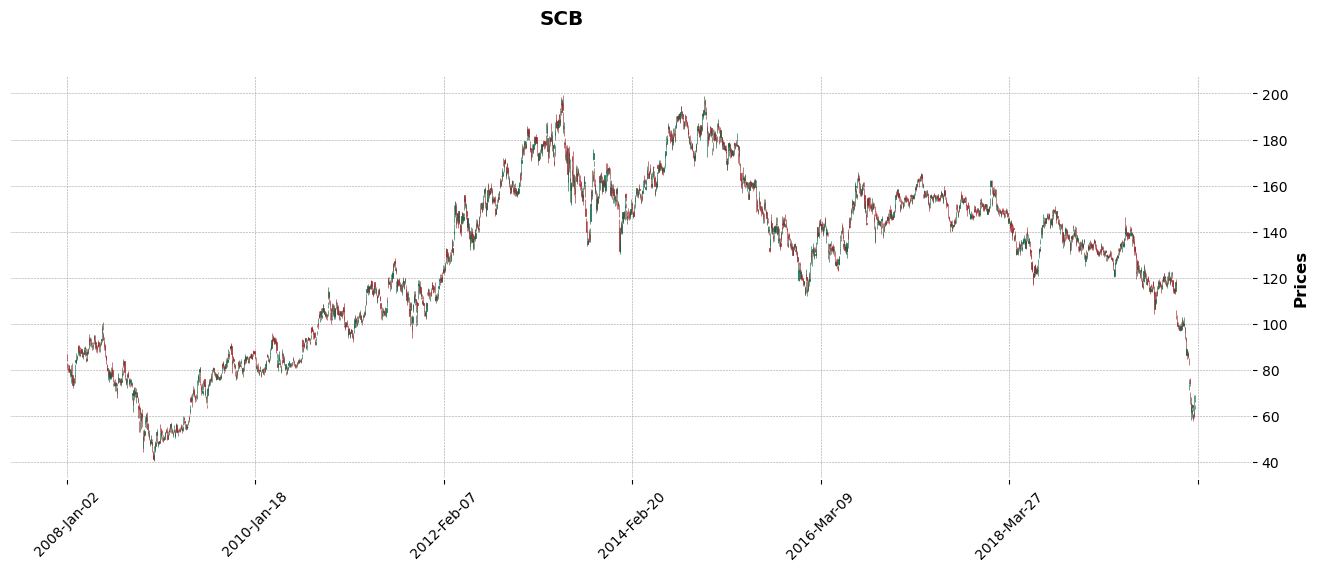

In [5]:
# Plot candlestick chart

# You can specify the date range for a chart by using the 'date_start' and 'date_end' parameters
date_start = '2007-01-01' # example: 20200101 format is YYYYmmdd or 2020-01-01 format is YYYY-mm-dd
date_end = '2022-12-31' # example: 20200131 format is YYYYmmdd or 2020-01-31 format is YYYY-mm-dd
window_chart = 2000 # candles

chart_width = 30 # ระบุความกว้า่ง
chart_height = 10 # ระบุความสูง

sample_symbol = 'SCB'

df_symbol = symbols[sample_symbol]

df_ohlc = build_ohlc_df(df_symbol)

# Get sub data
df_ohlc = data_range(df_ohlc, from_date=date_start, to_date=date_end, window=window_chart)

df_ohlc['DATETIME'] = pd.to_datetime(df_ohlc['DATETIME'], format=datetime_format)
df_ohlc.set_index('DATETIME', inplace=True)

plot_ohlc(df_ohlc
            , type='candle' # type='line'
            , style='charles'
            , title=sample_symbol
            , ylabel='Prices'
            , figratio=(chart_width, chart_height),)

## Create your own scanner extended from BaseScanner

The following code is a sample child class 'MyDailyScanner' that extends from BaseScanner. You need to implement function add_indi and eval_condition. The success key of your scanner is the conditions in eval_condition. Please pay attention to eval_condition implementation.

In [6]:
class MyDailyScanner(BaseScanner):

    def add_indi(self):
        
        def create_indi(symbol_name, dataset):

            # SMA
            dataset['MA1'] = pdta.sma(dataset['CLOSE'], 10)

            # WMA
            dataset['MA2'] = pdta.wma(dataset['CLOSE'], 50)

            # EMA
            dataset['MA3'] = pdta.ema(dataset['CLOSE'], 200)

            # RSI
            dataset['RSI_S'] = pdta.rsi(dataset['CLOSE'], 10)
            dataset['RSI_M'] = pdta.ema( pdta.rsi(dataset['CLOSE'], 28), 10 )

            # MACD
            df_macd_s = pdta.macd(dataset['CLOSE'], 12, 26, 9)
            dataset['MACD_S'] = df_macd_s.iloc[:, 0]
            dataset['MACD_HIST_S'] = df_macd_s.iloc[:, 1]
            dataset['MACD_SIGNAL_S'] = df_macd_s.iloc[:, 2]

            # ATR
            dataset['ATR'] = pdta.atr(dataset['HIGH']
                                      , dataset['LOW']
                                      , dataset['CLOSE']
                                      , 20)

            # NATR (Normalized Average True Range)
            dataset['NATR'] = pdta.natr(dataset['HIGH']
                                      , dataset['LOW']
                                      , dataset['CLOSE']
                                      , 20)
            dataset['NATR'] = dataset['NATR']

            # Slow Stochastics
            df_slow_s = pdta.stoch(dataset['HIGH']
                                   , dataset['LOW']
                                   , dataset['CLOSE']
                                   , 9, 3, 3, 'wma')
            dataset['STOCHK_S'] = df_slow_s.iloc[:, 0]
            dataset['STOCHD_S'] = df_slow_s.iloc[:, 1]

            # Slow Stochastics
            df_slow_m = pdta.stoch(dataset['HIGH']
                                   , dataset['LOW']
                                   , dataset['CLOSE']
                                   , 36, 12, 12, 'wma')
            dataset['STOCHK_M'] = df_slow_m.iloc[:, 0]
            dataset['STOCHD_M'] = df_slow_m.iloc[:, 1]

            dataset.fillna(0.0, inplace=True) # fill ค่า NaN ด้วยค่า 0.0
    
        #==============================================================================
        for symbol_name in self.symbols.keys():
            create_indi(symbol_name, self.symbols[symbol_name])

            
    def eval_condition(self, symbol_name, dataset):
        result = False

        predict_result = np.where((dataset.RSI_S > 45)
                                 , 1, 0)
        if predict_result[-1] == 1:
            result = True

        return result


## Create and add indicators

Create an instance of your scanner and call 'add_indi' function for calculating indicators and add them to scanner object.

In [7]:
scanner = MyDailyScanner(symbols)
scanner.add_indi()

scanner.symbols[sample_symbol]

DATETIME   OPEN   HIGH    LOW  CLOSE    VOLUME     MA1        MA2  \
0    1984-01-04  16.32  16.32  16.32  16.32     27613   0.000   0.000000   
1    1984-01-05  16.25  16.25  16.25  16.25     73200   0.000   0.000000   
2    1984-01-06  16.25  16.32  16.25  16.32     11720   0.000   0.000000   
3    1984-01-09  16.32  16.32  16.32  16.32       675   0.000   0.000000   
4    1984-01-10  16.32  16.32  16.25  16.32      5500   0.000   0.000000   
...         ...    ...    ...    ...    ...       ...     ...        ...   
8808 2020-03-25  61.00  61.75  59.25  60.75  16970700  62.300  80.789216   
8809 2020-03-26  60.75  64.75  60.00  64.00  19923800  62.075  79.805294   
8810 2020-03-27  65.75  69.25  65.00  66.25  33653000  62.050  78.948824   
8811 2020-03-30  64.00  65.00  63.25  64.50  14345600  62.275  78.064314   
8812 2020-03-31  67.25  69.25  66.00  69.25  21110900  63.000  77.407255   

             MA3      RSI_S      RSI_M    MACD_S  MACD_HIST_S  MACD_SIGNAL_S  \
0       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
1       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
2       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
3       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
4       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
...          ...        ...        ...       ...          ...            ...   
8808  109.350219  26.945124  25.197395 -9.360855    -0.383544      -8.977311   
8809  108.898973  36.660135  26.212871 -8.788435     0.151101      -8.939536   
8810  108.474605  42.538145  27.511051 -8.060318     0.703375      -8.763692   
8811  108.037047  39.379934  28.396847 -7.537601     0.980873      -8.518474   
8812  107.651106  50.470207  30.051799 -6.663249     1.484180      -8.147429   

           ATR      NATR   STOCHK_S   STOCHD_S   STOCHK_M  STOCHD_M  
0     0.000000  0.000000   0.000000   0.000000   0.000000  0.000000  
1     0.000000  0.000000   0.000000   0.000000   0.000000  0.000000  
2     0.000000  0.000000   0.000000   0.000000   0.000000  0.000000  
3     0.000000  0.000000   0.000000   0.000000   0.000000  0.000000  
4     0.000000  0.000000   0.000000   0.000000   0.000000  0.000000  
...        ...       ...        ...        ...        ...       ...  
8808  3.807356  6.267253  16.319396  14.312851   7.006479  7.492726  
8809  3.854488  6.022638  48.986100  31.692394   7.880900  7.637450  
8810  3.924264  5.923417  66.944663  52.520931   9.455805  7.980576  
8811  3.878051  6.012482  66.236559  63.597517  10.286134  8.393495  
8812  3.921648  5.663030  81.481481  73.977038  12.589171  9.088697  

[8813 rows x 20 columns]

### Visualize candles and indicators

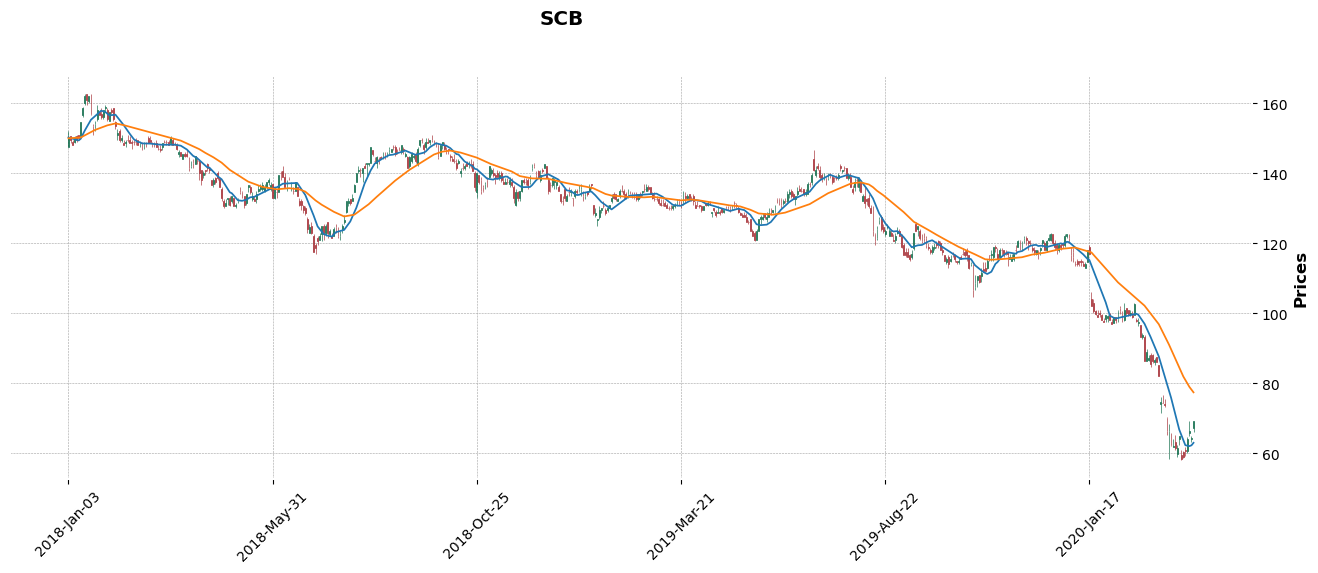

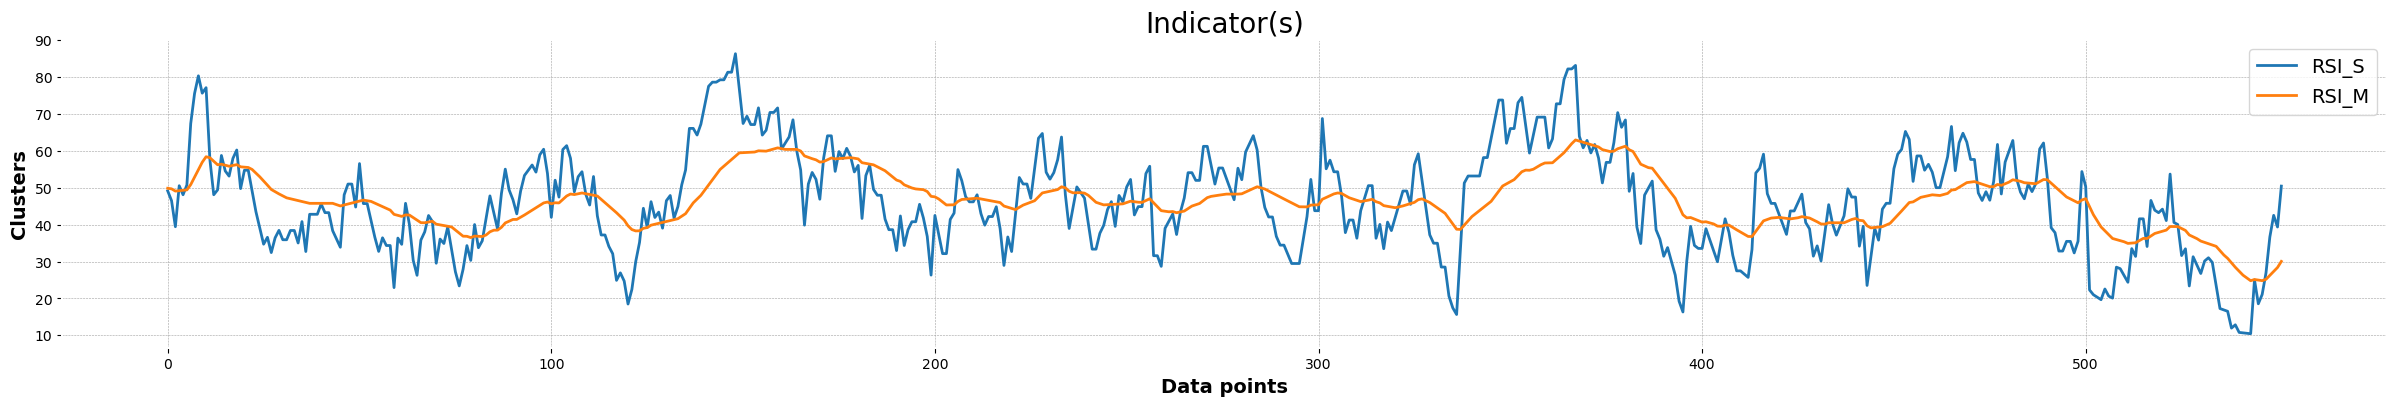

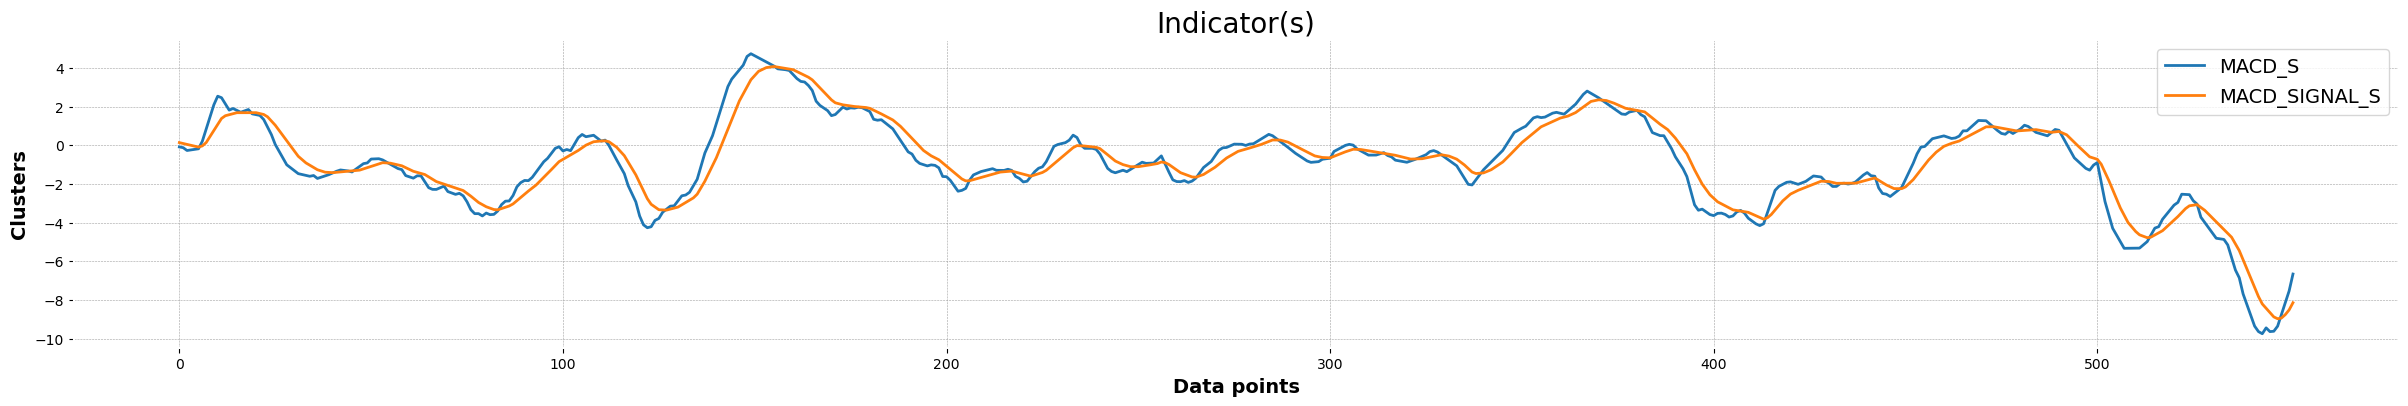

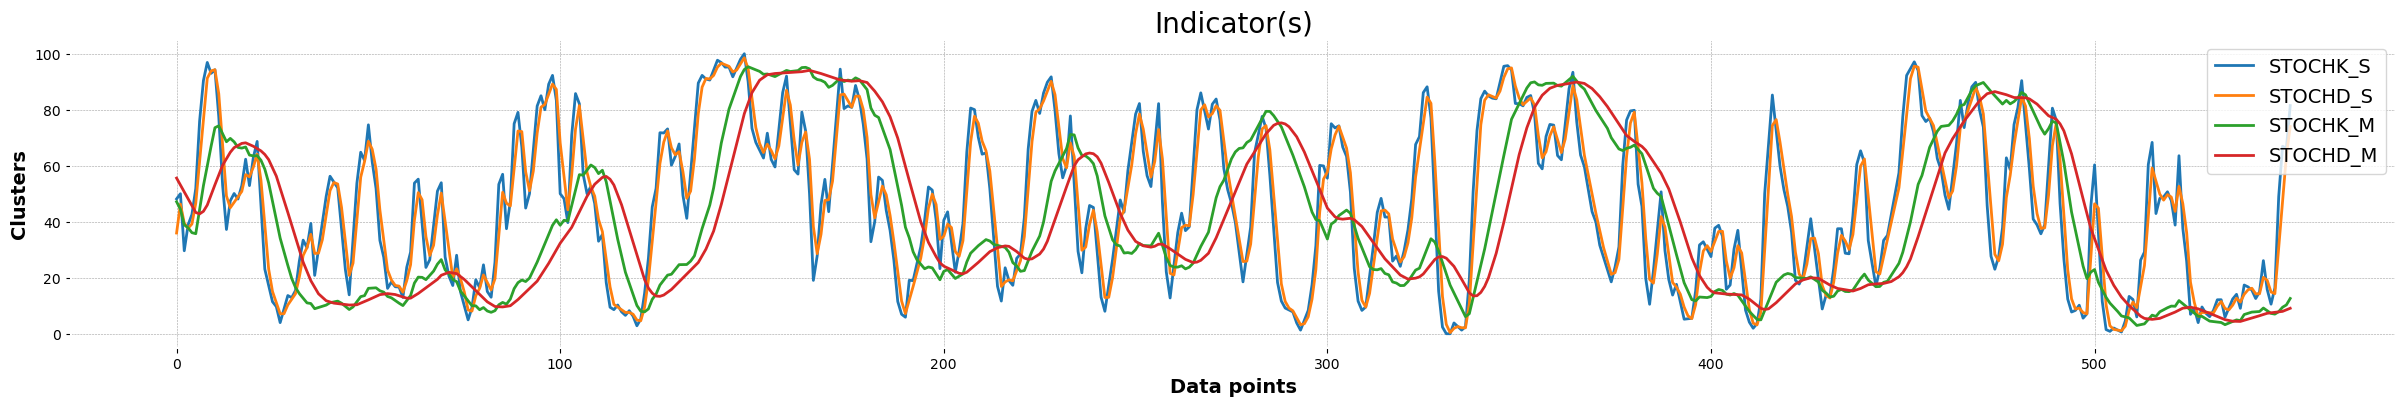

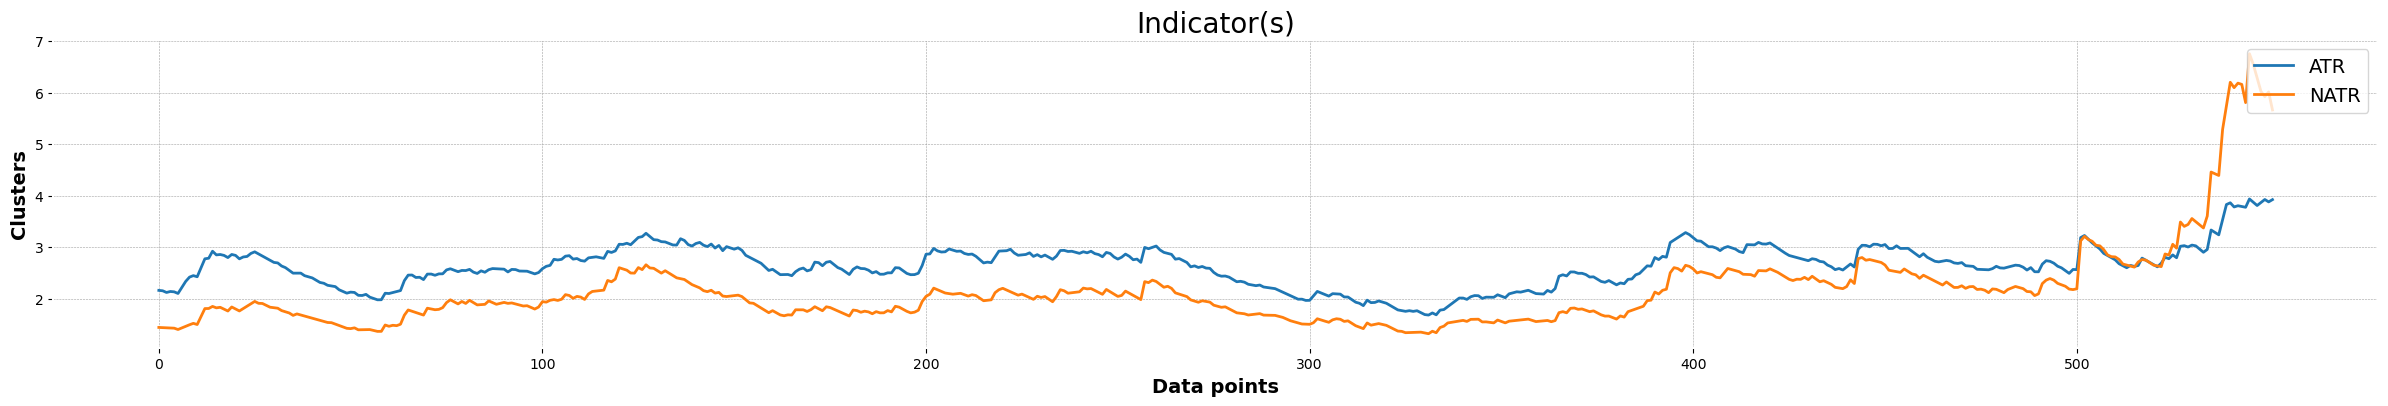

In [8]:
# You can specify the date range for a chart by using the 'date_start' and 'date_end' parameters
date_start = '2017-01-01' # example: 20200101 format is YYYYmmdd or 2020-01-01 format is YYYY-mm-dd
date_end = '2022-12-31' # example: 20200131 format is YYYYmmdd or 2020-01-31 format is YYYY-mm-dd
window_chart = 2000 # candles

chart_width = 30 # ระบุความกว้า่ง
chart_height = 10 # ระบุความสูง

# Get sub data
df = data_range(scanner.symbols[sample_symbol], from_date=date_start, to_date=date_end, window=window_chart)
new_total_rows = df.shape[0]
    

df_ohlc = build_ohlc_df(df)

# Get sub data
df_ohlc = data_range(df_ohlc, from_date=date_start, to_date=date_end, window=window_chart)

df_ohlc['DATETIME'] = pd.to_datetime(df_ohlc['DATETIME'], format=datetime_format)
df_ohlc.set_index('DATETIME', inplace=True)
    
#===============================================================================================

# Plot candles chart

apdict_ma1 = mpf.make_addplot(df['MA1'])
apdict_ma2 = mpf.make_addplot(df['MA2'])
plot_ohlc(df_ohlc
            , type='candle' # type='line'
            , style='charles'
            , title=sample_symbol
            , ylabel='Prices'
            , figratio=(chart_width, chart_height)
            , addplot=[apdict_ma1, apdict_ma2]
            ,)

#===============================================================================================

def plot_indi(data, cols):    
    for i in range(0, len(cols)):
        x = np.arange(new_total_rows)
        y = data[cols[i]]
        plt.plot(x, y, label=cols[i])

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_S', 'RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['MACD_S', 'MACD_SIGNAL_S'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['STOCHK_S', 'STOCHD_S', 'STOCHK_M', 'STOCHD_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['ATR', 'NATR'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

## Start scan

You can start scanning data by calling the 'scan' function. The amount of time it takes to run this function may vary depending on the number of symbols and the size of the data being used.

In [9]:
# start scanning
scanned_symbols = scanner.scan(info=True)
# To round a number to the nearest integer, you can use the 'round' function in Python.
scanned_symbols = scanned_symbols.round(4)

scanned_symbols

SYMBOL  SCAN_RESULT      MA1       MA2       MA3    RSI_S    RSI_M  \
0    GUNKUL         True    2.059    2.3074    2.7223  53.1852  36.4748   
1     BANPU        False    5.167    6.7575   11.0373  40.4277  28.5761   
2       SCB         True   63.000   77.4073  107.6511  50.4702  30.0518   
3       SCC         True  303.200  317.3435  377.5671  57.5726  43.3920   
4       TKN        False    4.953    6.8733    9.4710  39.8333  31.6964   
..      ...          ...      ...       ...       ...      ...      ...   
96     EGCO         True  212.350  247.0533  300.4761  52.6165  36.6091   
97      KKP        False   35.775   50.8863   63.2128  39.7337  26.0188   
98      TQM         True   65.150   67.8078   55.6785  54.6860  48.0023   
99      JAS         True    4.304    4.6756    5.3703  66.7766  42.4822   
100    ESSO         True    3.764    5.1961    7.7305  46.1071  35.3520   

      MACD_S  MACD_HIST_S  MACD_SIGNAL_S      ATR    NATR  STOCHK_S  STOCHD_S  \
0    -0.1143       0.0220        -0.1363   0.1252  5.6906   69.8599   59.0710   
1    -0.8209       0.1686        -0.9896   0.4358  8.2232   45.0766   46.0563   
2    -6.6632       1.4842        -8.1474   3.9216  5.6630   81.4815   73.9770   
3    -4.4278       6.1385       -10.5663  15.7700  4.8673   87.8307   87.3188   
4    -0.9088       0.0893        -0.9981   0.5128  9.6752   64.6465   52.2081   
..       ...          ...            ...      ...     ...       ...       ...   
96  -14.8670       5.9400       -20.8070  16.0015  6.9271   83.9246   83.3229   
97   -6.6781       0.6380        -7.3161   2.7540  7.0614   79.2582   68.7347   
98   -1.0288       1.3027        -2.3315   5.1315  7.6305   55.9783   57.0646   
99   -0.1205       0.0948        -0.2153   0.2310  4.7135   87.4074   86.3283   
100  -0.6434       0.0794        -0.7228   0.4094  9.6549   80.6699   68.5711   

     STOCHK_M  STOCHD_M  
0     23.4375   20.2585  
1     15.4994   13.1836  
2     12.5892    9.0887  
3     49.9596   37.3137  
4      6.4788    5.5477  
..        ...       ...  
96    35.5896   25.8158  
97    11.2404    9.7717  
98    47.6258   37.7892  
99    36.8008   24.8224  
100   14.4608   10.9424  

[101 rows x 16 columns]

### Show qualified symbols

The code below is for exploring data that has passed the scanning conditions.

In [10]:
scanned_symbols.loc[(scanned_symbols.SCAN_RESULT == True)]

SYMBOL  SCAN_RESULT      MA1       MA2       MA3    RSI_S    RSI_M  \
0    GUNKUL         True    2.059    2.3074    2.7223  53.1852  36.4748   
2       SCB         True   63.000   77.4073  107.6511  50.4702  30.0518   
3       SCC         True  303.200  317.3435  377.5671  57.5726  43.3920   
5     COM-7         True   25.830   27.1218   24.1038  51.2896  46.2595   
6       BBL         True   93.900  116.2927  156.9408  45.5098  30.8012   
9     HMPRO         True   10.655   12.4463   15.1275  45.5643  37.9630   
13      CPN         True   39.275   49.4949   61.7035  46.3021  36.2133   
14    RATCH         True   54.375   57.8806   64.9118  53.0811  41.8295   
23      PRM         True    3.760    4.3670    6.4459  57.9713  40.8889   
26   ADVANC         True  195.150  195.8890  207.5753  57.8665  47.4172   
27      BGC         True    7.860   10.1708   12.3183  45.3188  31.3311   
32      BJC         True   38.975   37.9522   44.4990  58.4349  49.0619   
37       EA         True   32.825   38.0233   43.9170  46.3044  40.2276   
38     GULF         True  144.450  160.1745  153.6830  50.0280  42.9252   
41      BEM         True    7.210    8.7203   10.1750  47.9934  33.7222   
42      TOA         True   30.750   32.3153   36.8108  49.6761  41.7536   
44     GPSC         True   54.850   62.2288   71.1061  49.5197  40.1097   
45      PTT         True   29.025   34.3810   42.3612  49.0504  36.2560   
48     BCPG         True   11.570   13.5132   16.3516  49.7743  37.9148   
49      CBG         True   59.675   69.8045   75.1334  50.0782  39.9534   
50    SUPER         True    0.326    0.3933    0.5422  48.2235  31.3669   
52      KTB         True   10.560   12.6925   15.9881  49.7305  31.1684   
53     DTAC         True   35.800   36.8325   48.3459  65.0907  43.2540   
54    PTTGC         True   26.855   36.0354   51.5115  50.2231  32.7388   
55     HANA         True   20.920   27.6989   30.4594  45.5758  35.2765   
61     IRPC         True    2.065    2.3006    3.5267  49.8586  37.8373   
62      SGP         True    7.050    7.3609    8.6091  64.2776  45.1898   
64      TMB         True    0.768    1.0097    1.4891  51.5861  31.9827   
65      TTW         True   12.040   13.0939   13.3896  51.9359  42.0240   
66      IVL         True   18.530   23.4044   32.8735  53.5702  37.1629   
67      BPP         True   11.180   12.3865   17.0658  53.8481  38.6732   
69   CENTEL         True   14.270   17.8431   26.7353  45.4284  34.7000   
73    KBANK         True   85.625  107.8667  144.8737  45.7460  32.1420   
75      EPG         True    3.330    4.0977    5.9700  45.3229  32.3613   
81      STA         True   10.410   11.4449   11.3945  51.0382  47.0836   
84    BGRIM         True   38.525   44.3527   45.6265  47.9233  40.6608   
85     TRUE         True    3.002    3.2145    4.4430  54.6112  38.6324   
86   INTUCH         True   47.775   51.0871   57.6504  53.8917  41.6512   
88    SPALI         True   14.010   15.3729   17.8336  53.5121  40.1257   
89      OSP         True   34.950   38.7814   38.0944  47.7417  43.1665   
90     MEGA         True   20.090   23.3950   28.6710  53.2980  39.9651   
91       TU         True   13.930   14.3853   15.3542  48.0738  47.3863   
92       CK         True   14.480   17.0391   20.8528  47.6784  39.4492   
93      CPF         True   23.000   25.3151   26.8450  52.6718  43.1883   
96     EGCO         True  212.350  247.0533  300.4761  52.6165  36.6091   
98      TQM         True   65.150   67.8078   55.6785  54.6860  48.0023   
99      JAS         True    4.304    4.6756    5.3703  66.7766  42.4822   
100    ESSO         True    3.764    5.1961    7.7305  46.1071  35.3520   

      MACD_S  MACD_HIST_S  MACD_SIGNAL_S      ATR    NATR  STOCHK_S  STOCHD_S  \
0    -0.1143       0.0220        -0.1363   0.1252  5.6906   69.8599   59.0710   
2    -6.6632       1.4842        -8.1474   3.9216  5.6630   81.4815   73.9770   
3    -4.4278       6.1385       -10.5663  15.7700  4.8673   87.8307   87.3188   
5    

### Visualize candles and indicators for specified qualified symbol

The code below is for visualizing specified symbol that has passed the scanning conditions.

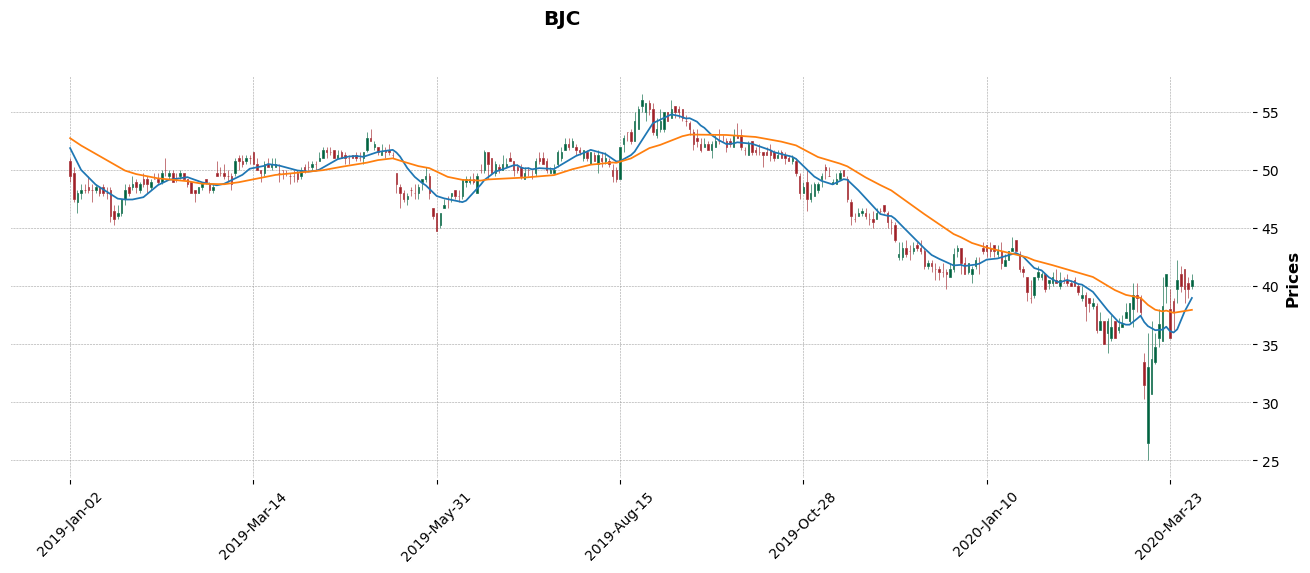

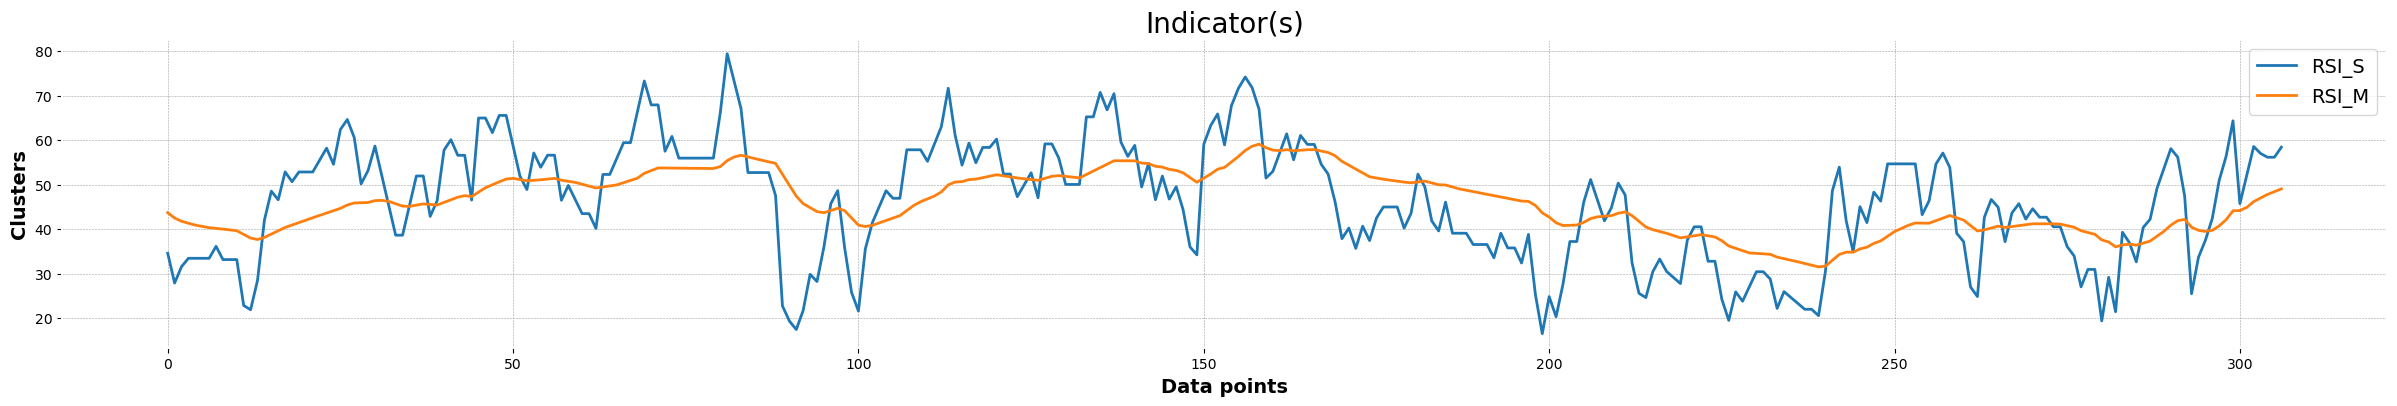

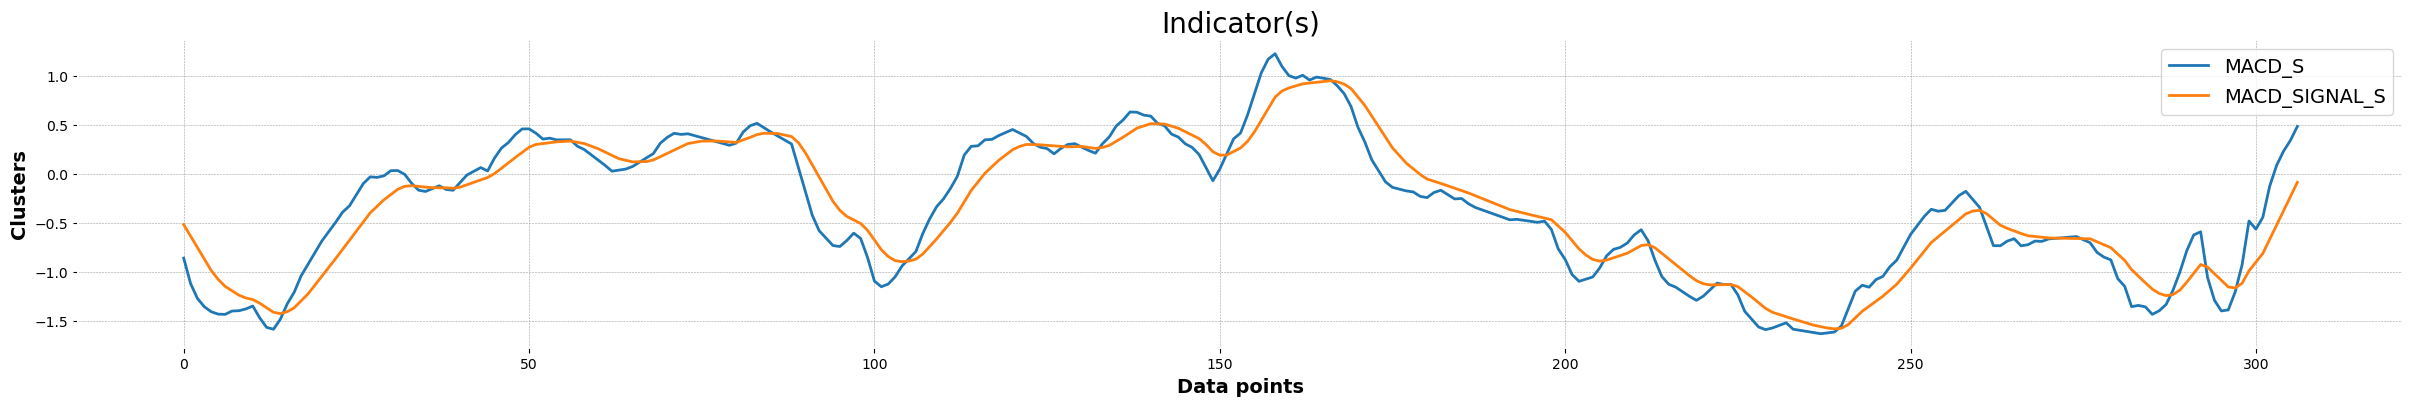

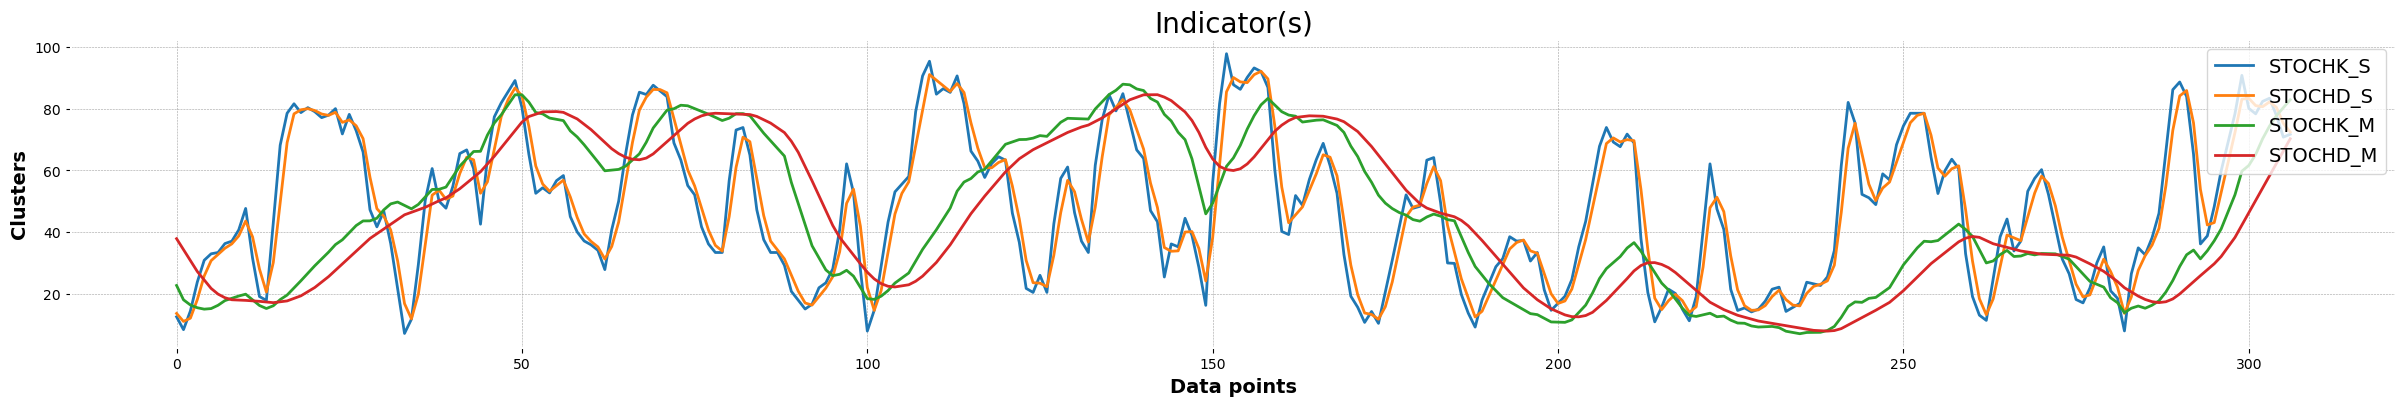

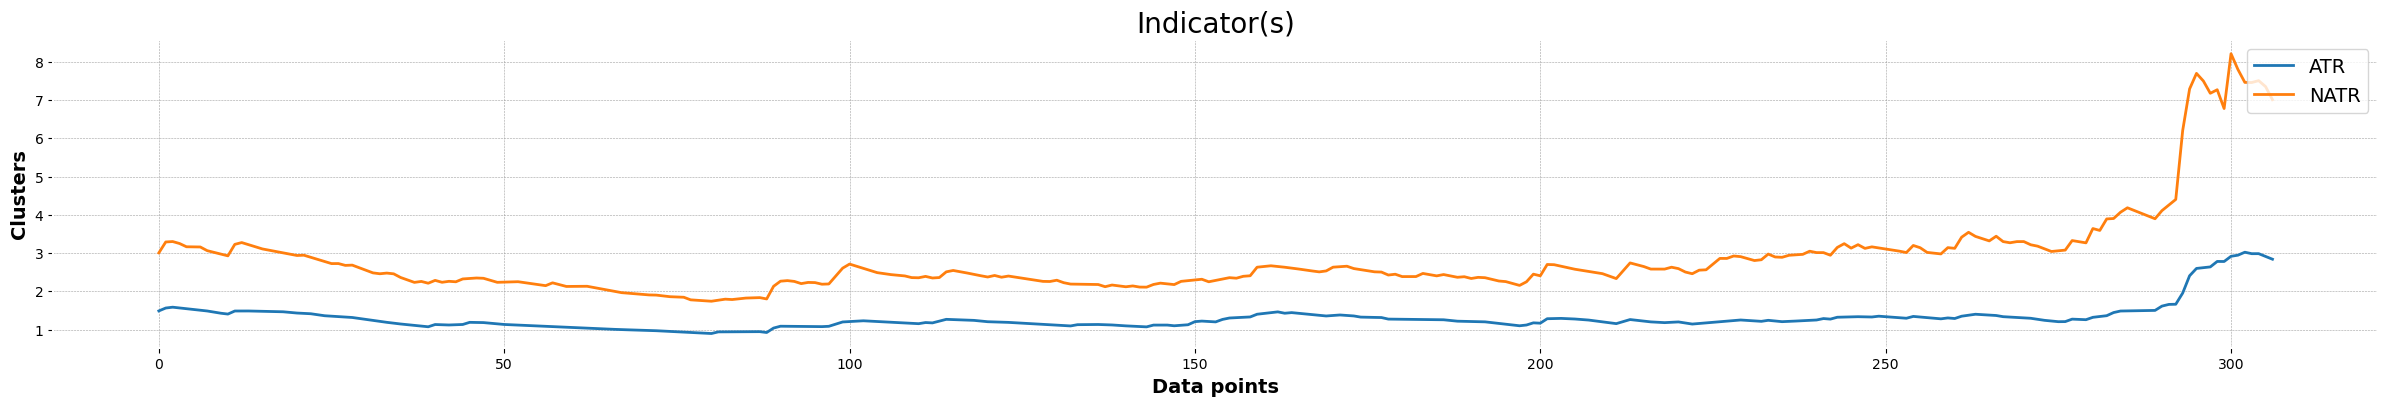

In [11]:
# Define symbol name for visualizing
scanned_symbol = 'BJC'


# You can specify the date range for a chart by using the 'date_start' and 'date_end' parameters
date_start = '2018-01-01' # example: 20200101 format is YYYYmmdd or 2020-01-01 format is YYYY-mm-dd
date_end = '2022-12-31' # example: 20200131 format is YYYYmmdd or 2020-01-31 format is YYYY-mm-dd
window_chart = 2000 # candles

chart_width = 30 # ระบุความกว้า่ง
chart_height = 10 # ระบุความสูง

# Get sub data
df = data_range(scanner.symbols[scanned_symbol], from_date=date_start, to_date=date_end, window=window_chart)
new_total_rows = df.shape[0]


df_ohlc = build_ohlc_df(df)

# Get sub data
df_ohlc = data_range(df_ohlc, from_date=date_start, to_date=date_end, window=window_chart)

df_ohlc['DATETIME'] = pd.to_datetime(df_ohlc['DATETIME'], format=datetime_format)
df_ohlc.set_index('DATETIME', inplace=True)
    
#===============================================================================================

# Plot candles chart
apdict_ma1 = mpf.make_addplot(df['MA1'])
apdict_ma2 = mpf.make_addplot(df['MA2'])
plot_ohlc(df_ohlc
                  , type='candle' # type='line'
                  , style='charles'
                  , title=scanned_symbol
                  , ylabel='Prices'
                  , figratio=(chart_width, chart_height)
                  , addplot=[apdict_ma1, apdict_ma2]
                  ,)

#===============================================================================================

def plot_indi(data, cols):    
    for i in range(0, len(cols)):
        x = np.arange(new_total_rows)
        y = data[cols[i]]
        plt.plot(x, y, label=cols[i])

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_S', 'RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['MACD_S', 'MACD_SIGNAL_S'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['STOCHK_S', 'STOCHD_S', 'STOCHK_M', 'STOCHD_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['ATR', 'NATR'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

### Visualize candles of all qualified symbols

<b>CAUTION:</b> If the conditions written in the code for the add_indi() function above are broad, it will result in a large number of symbols that pass the criteria or are scanned. When visualizing the chart in this cell, it may take a long time to run and the file may become large. When finished viewing the visualization results, it is recommended to always clear the output of this cell to free memory.

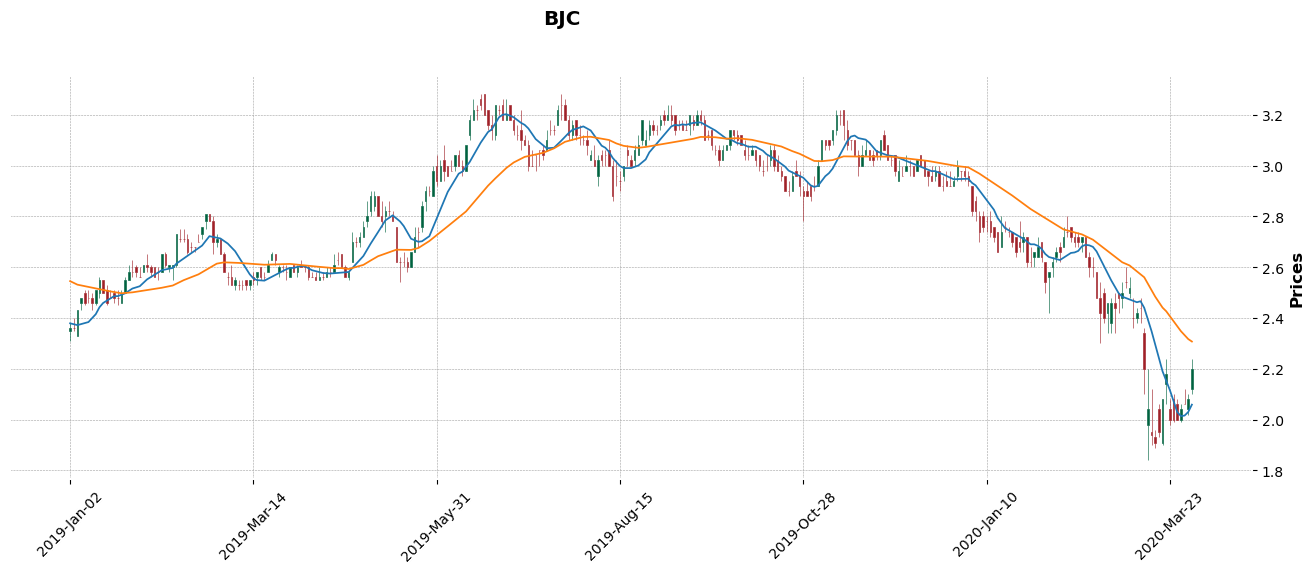

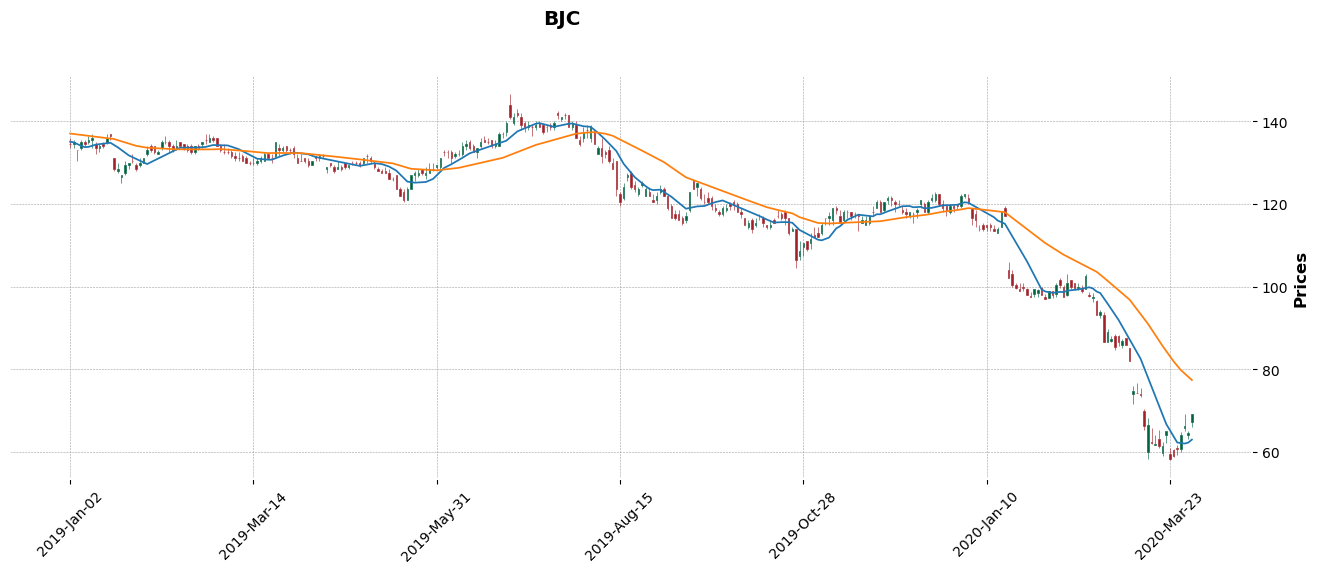

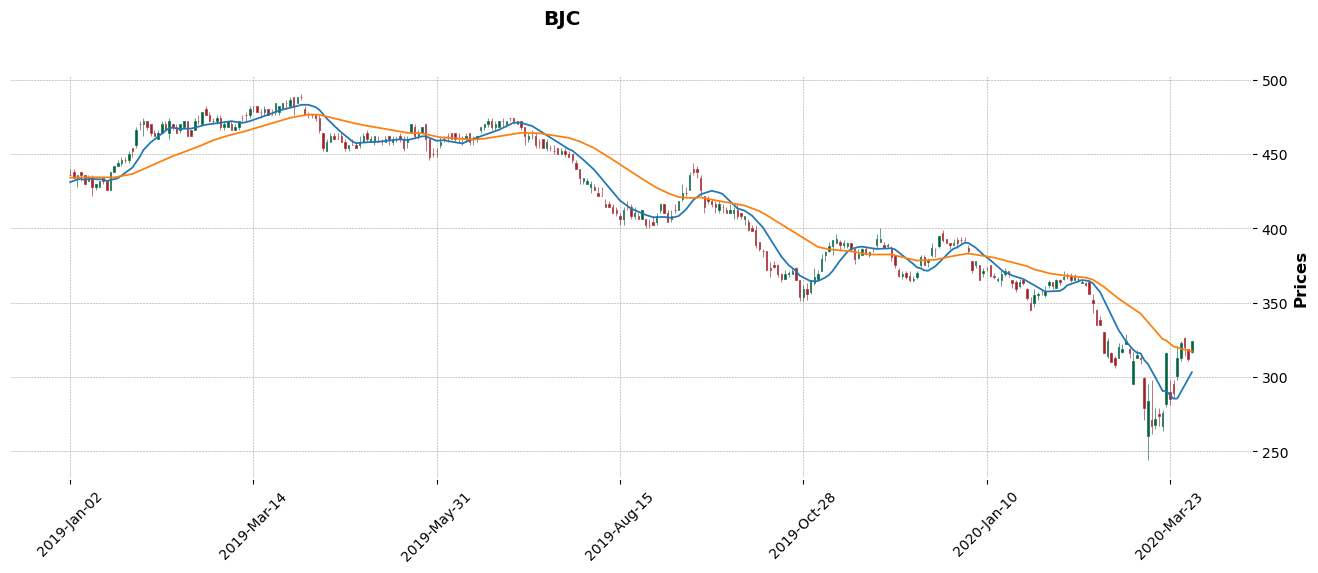

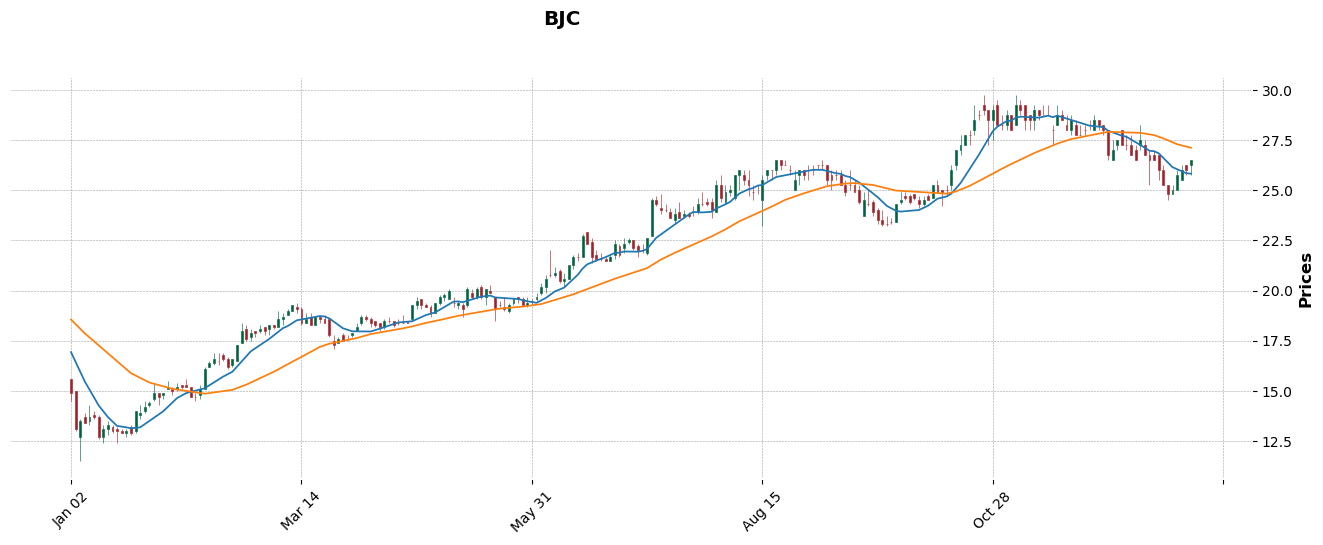

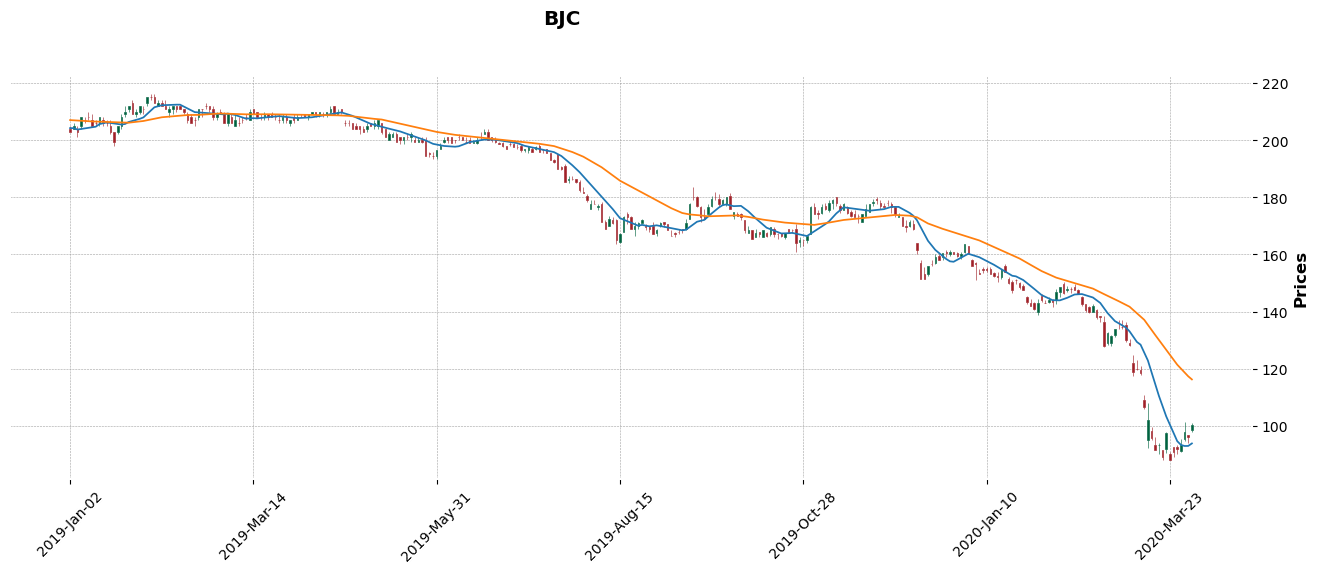

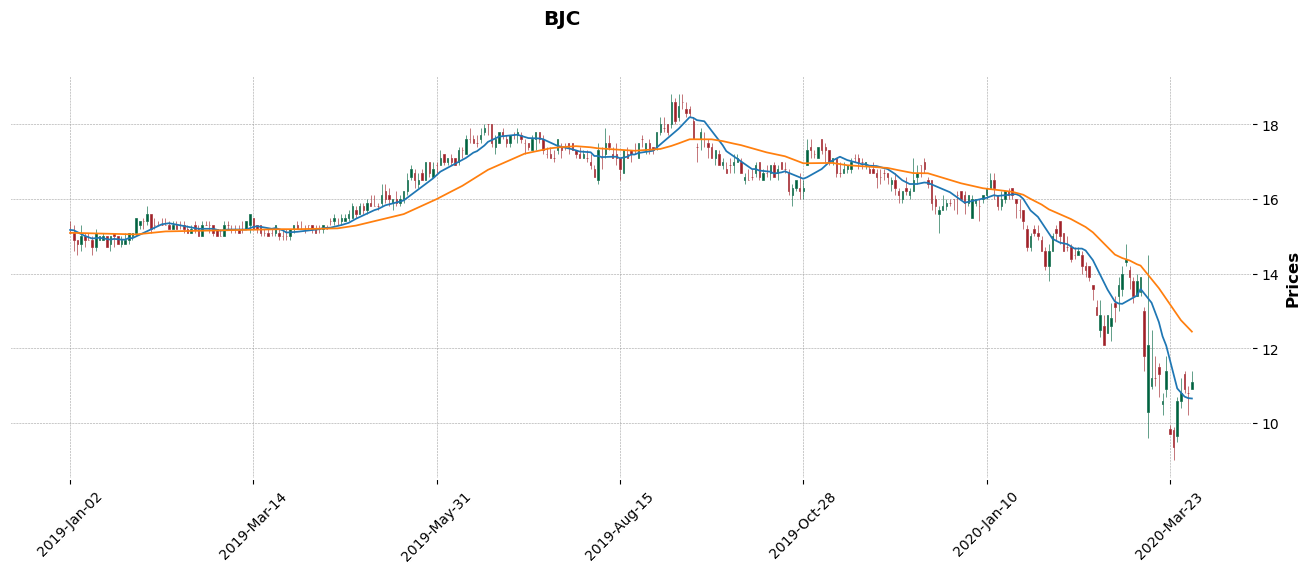

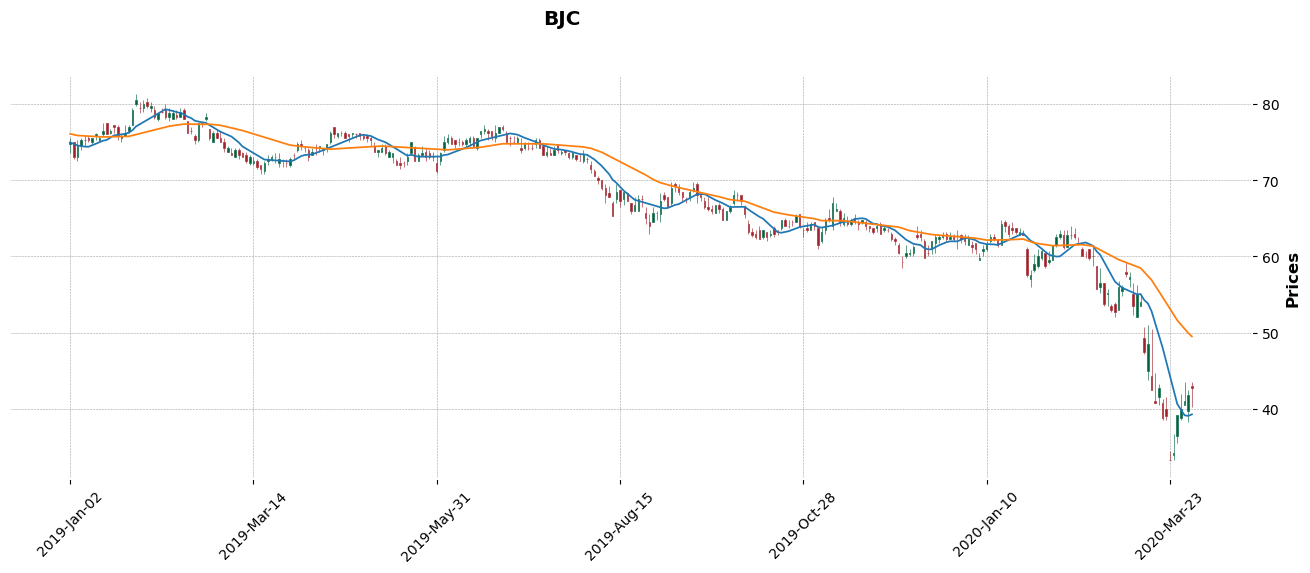

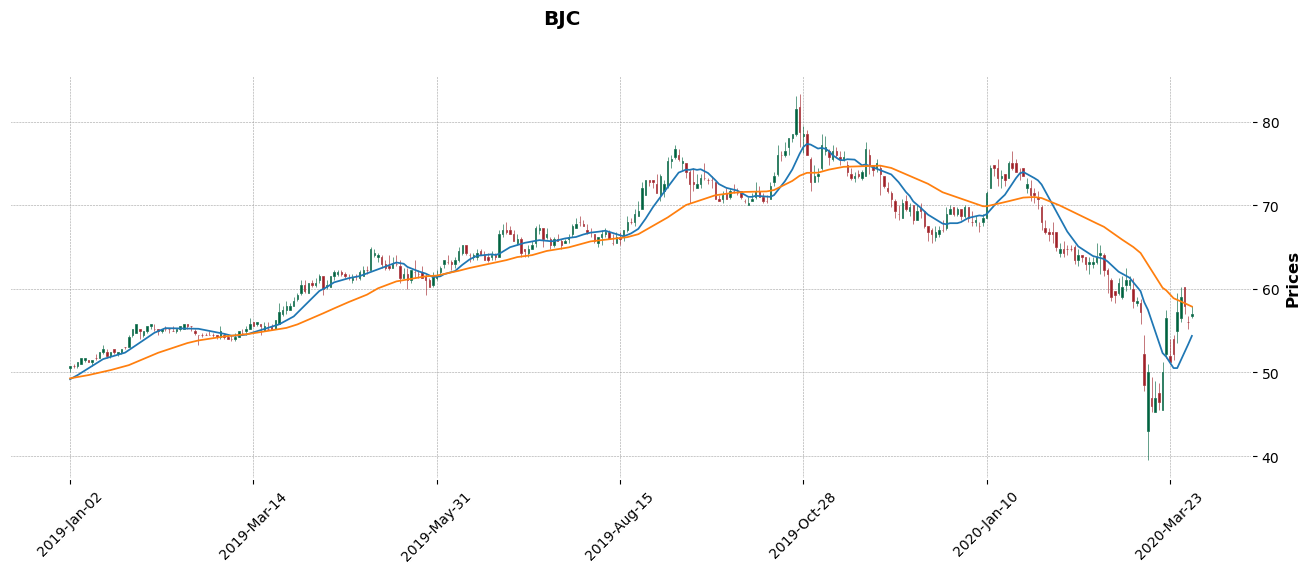

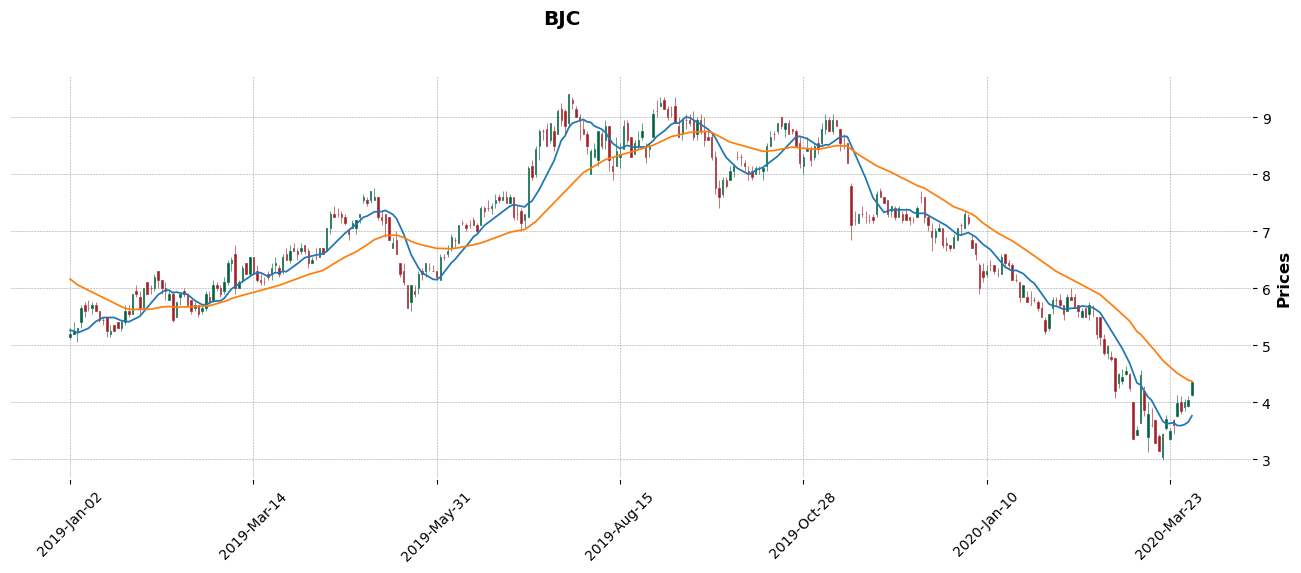

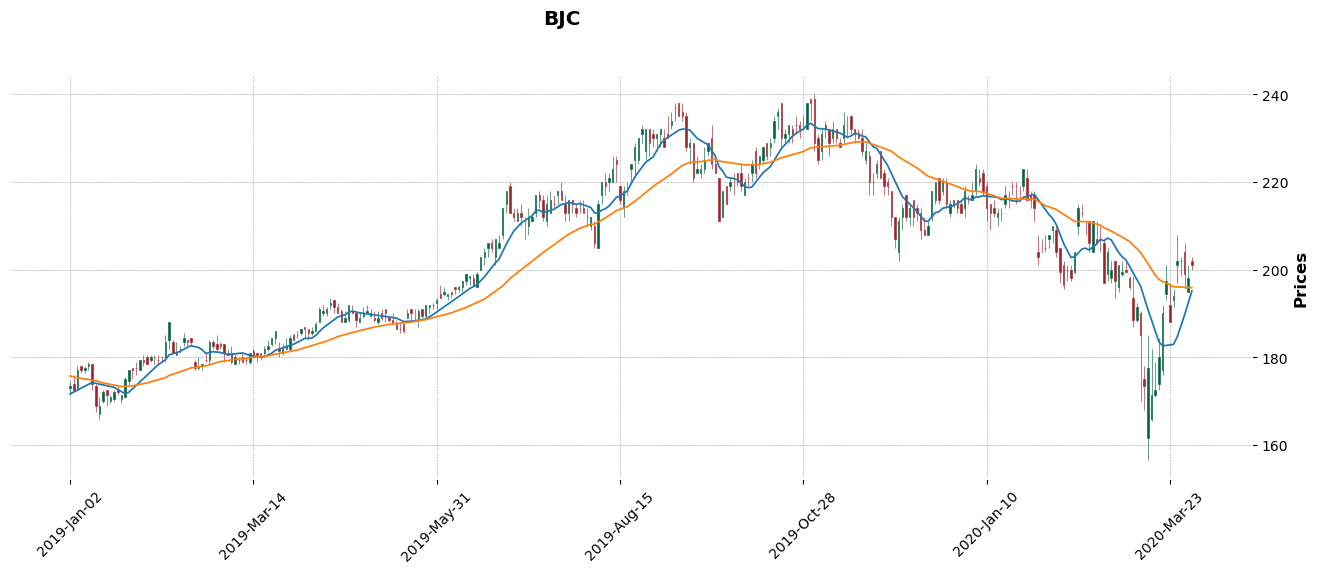

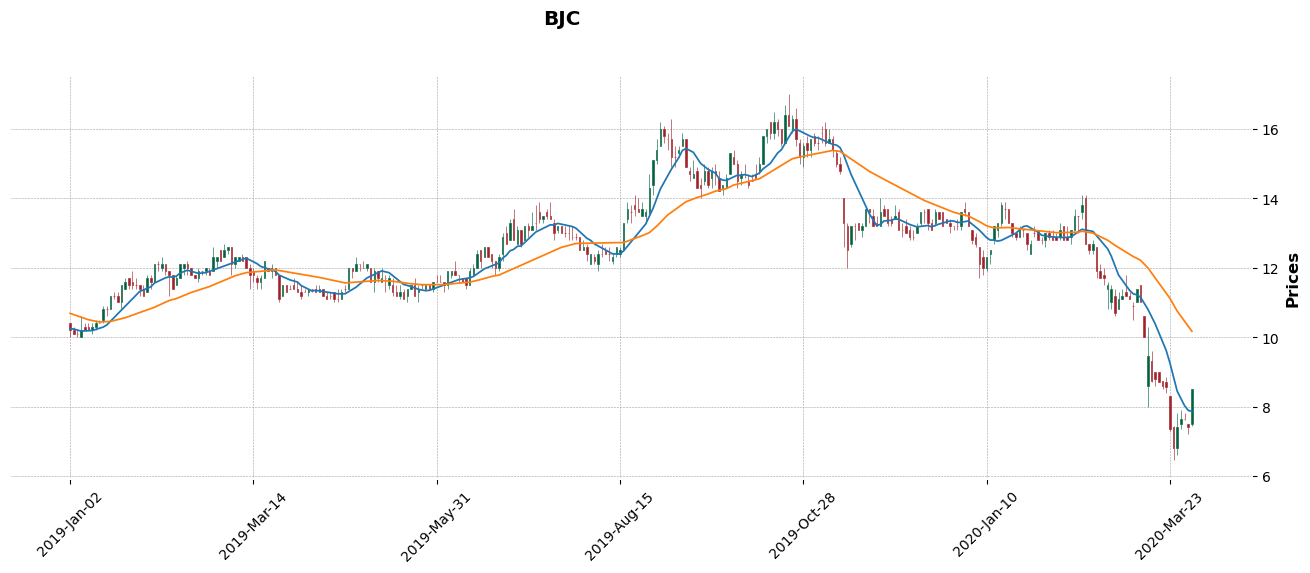

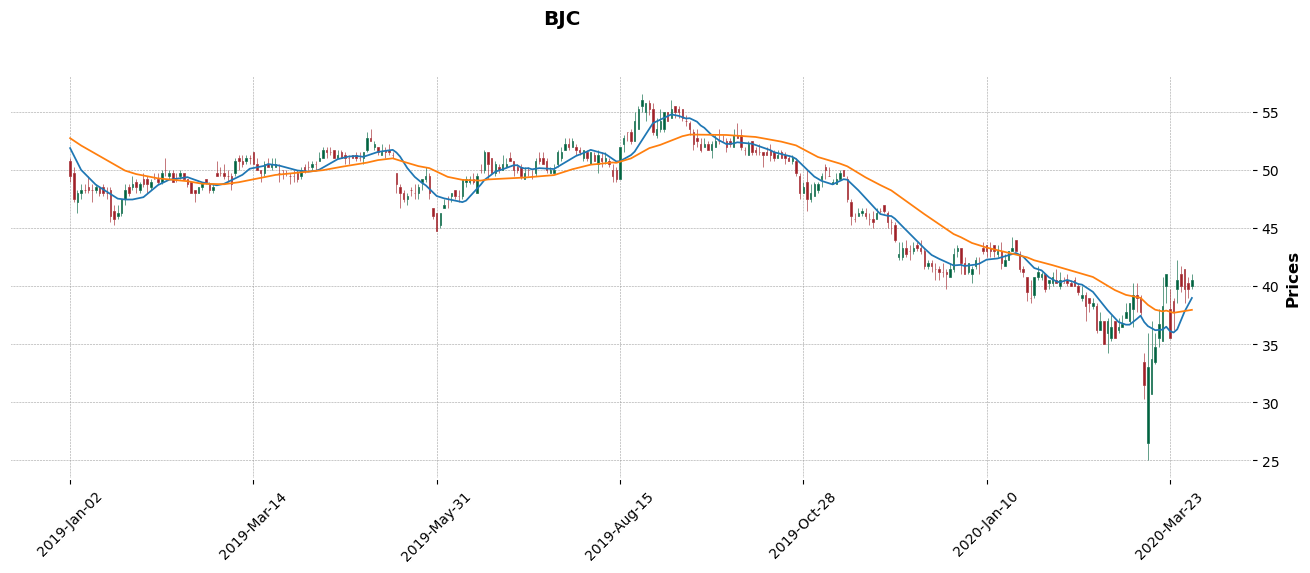

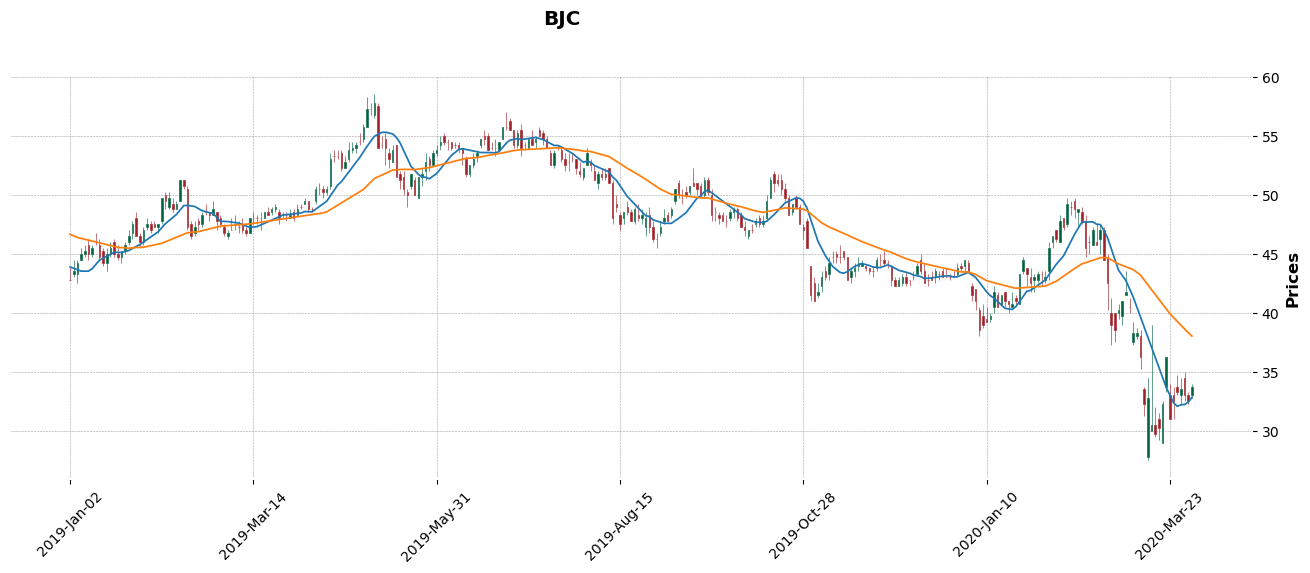

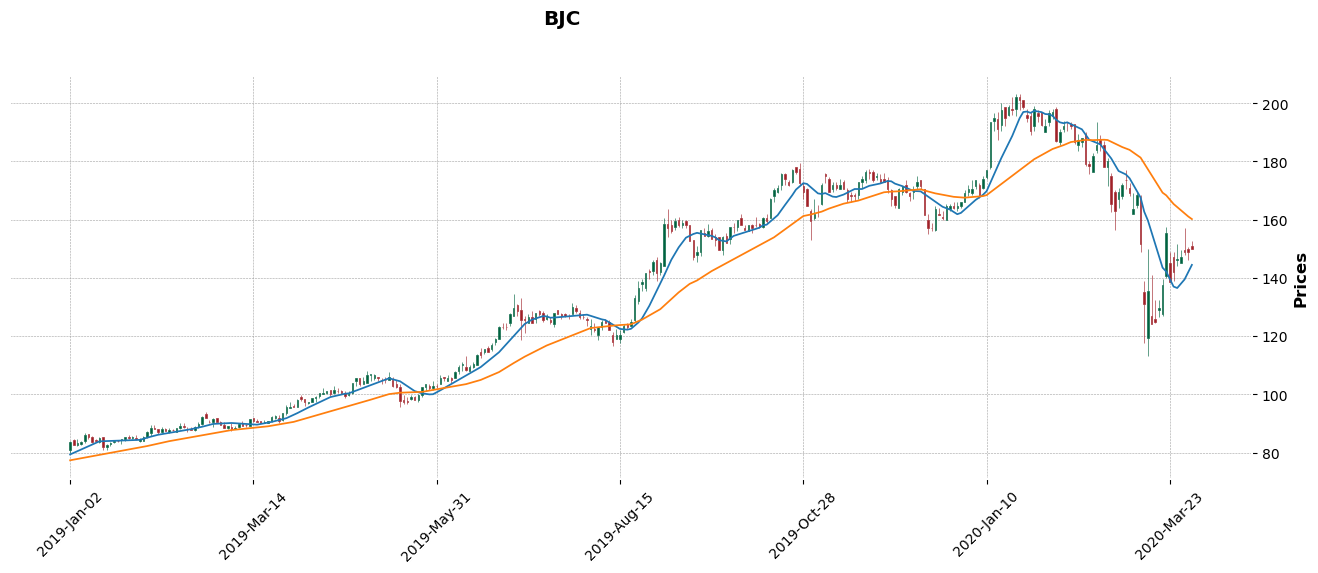

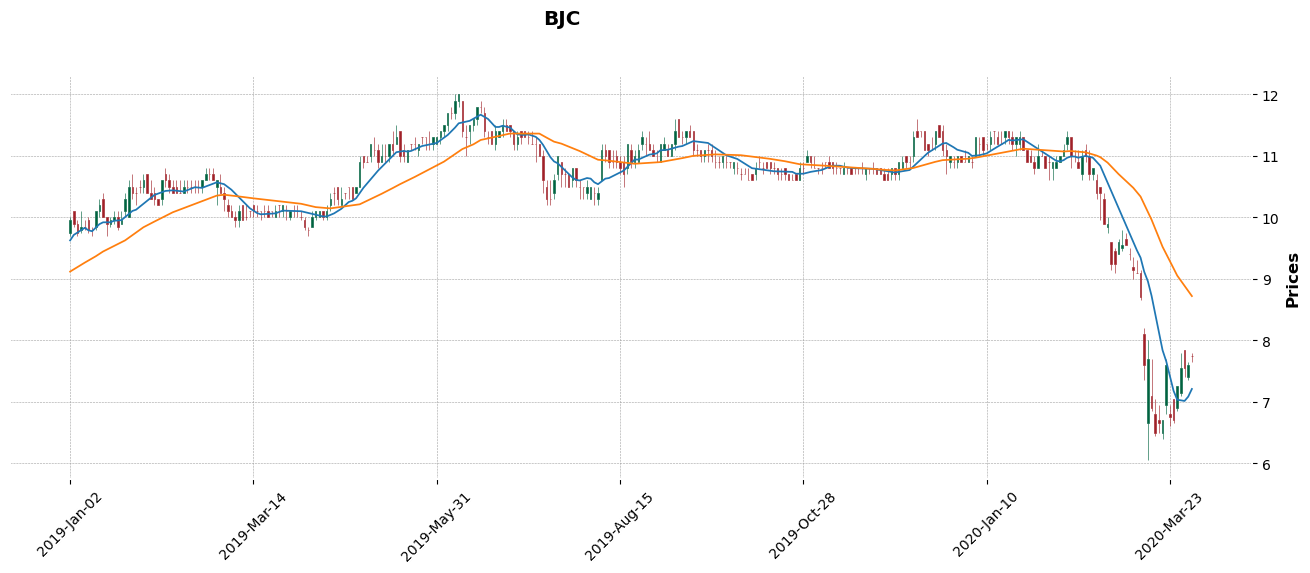

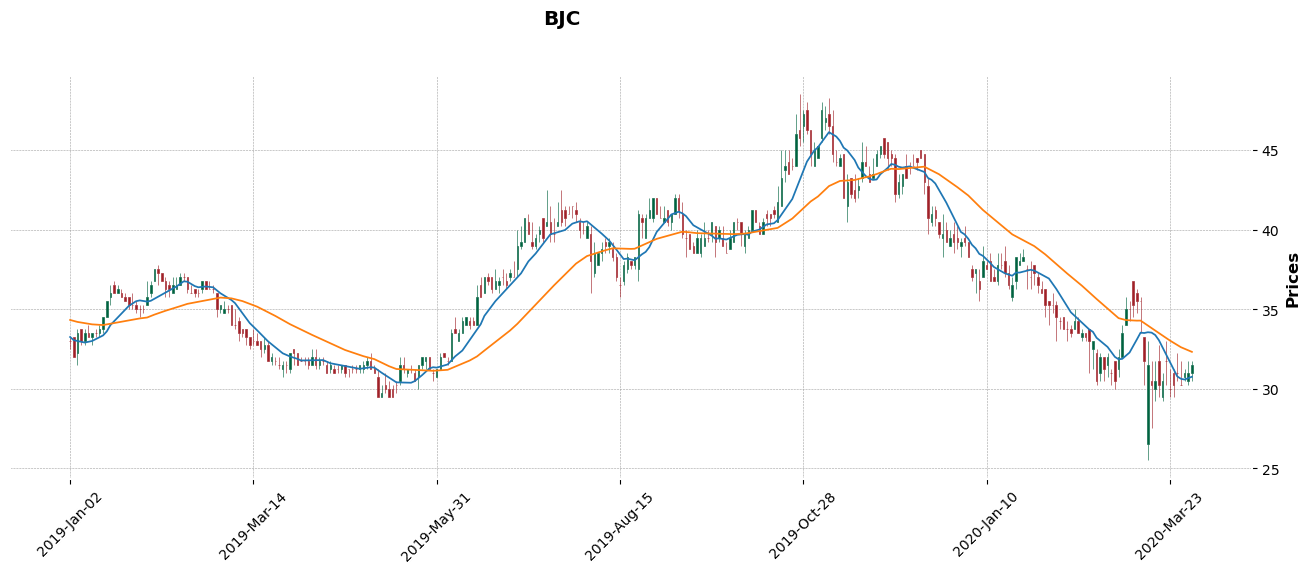

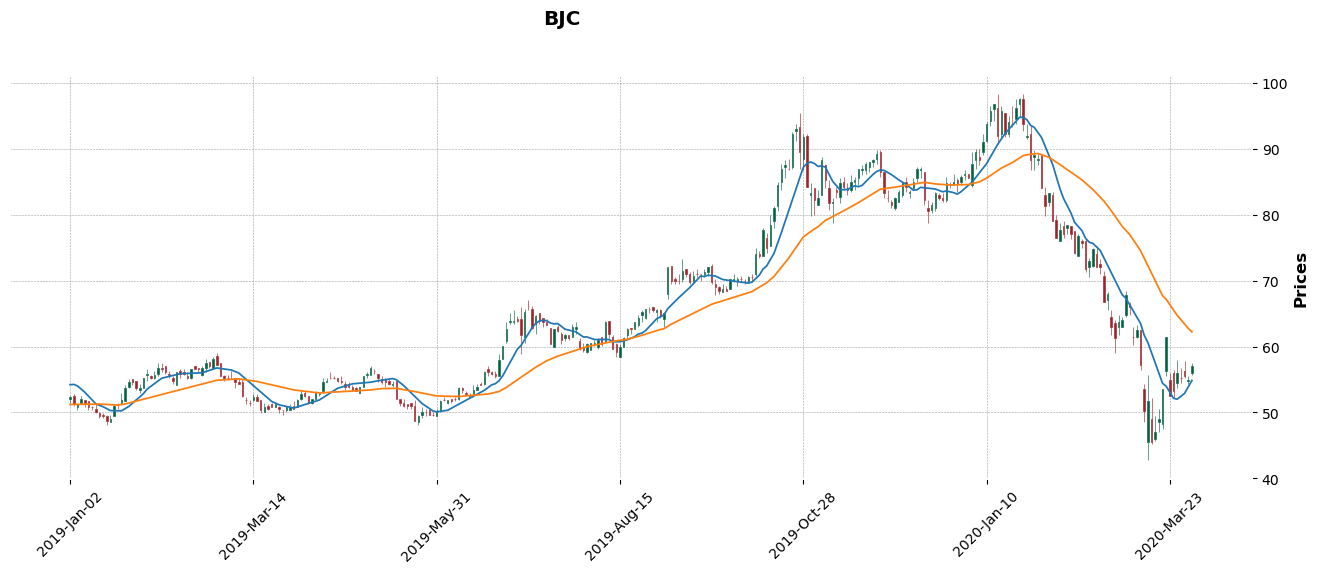

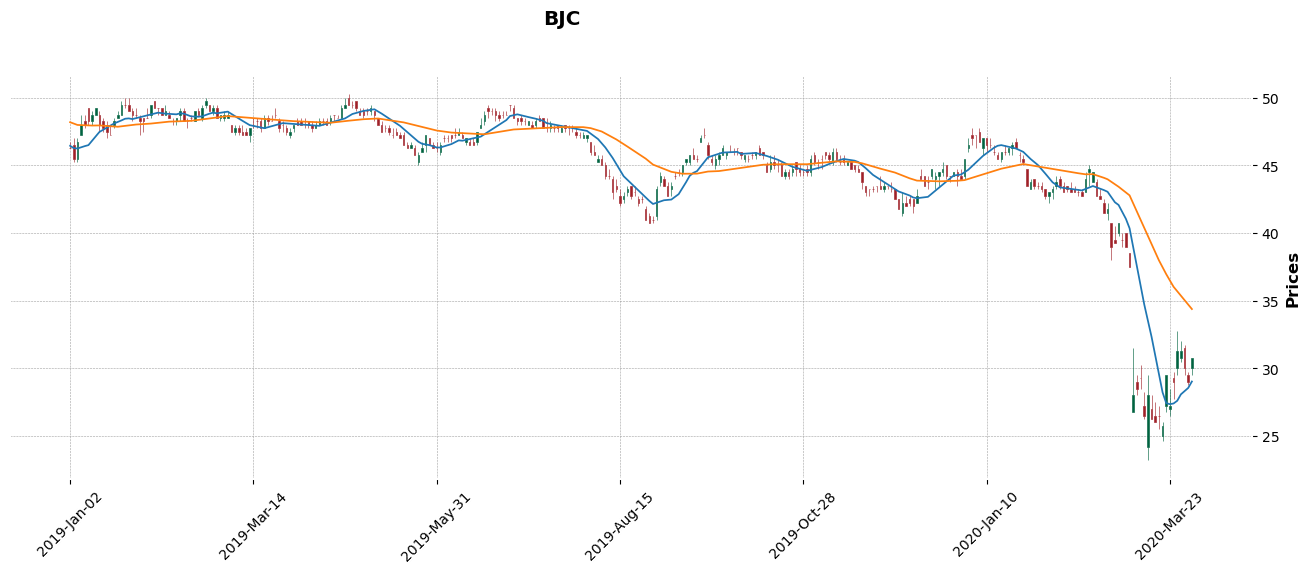

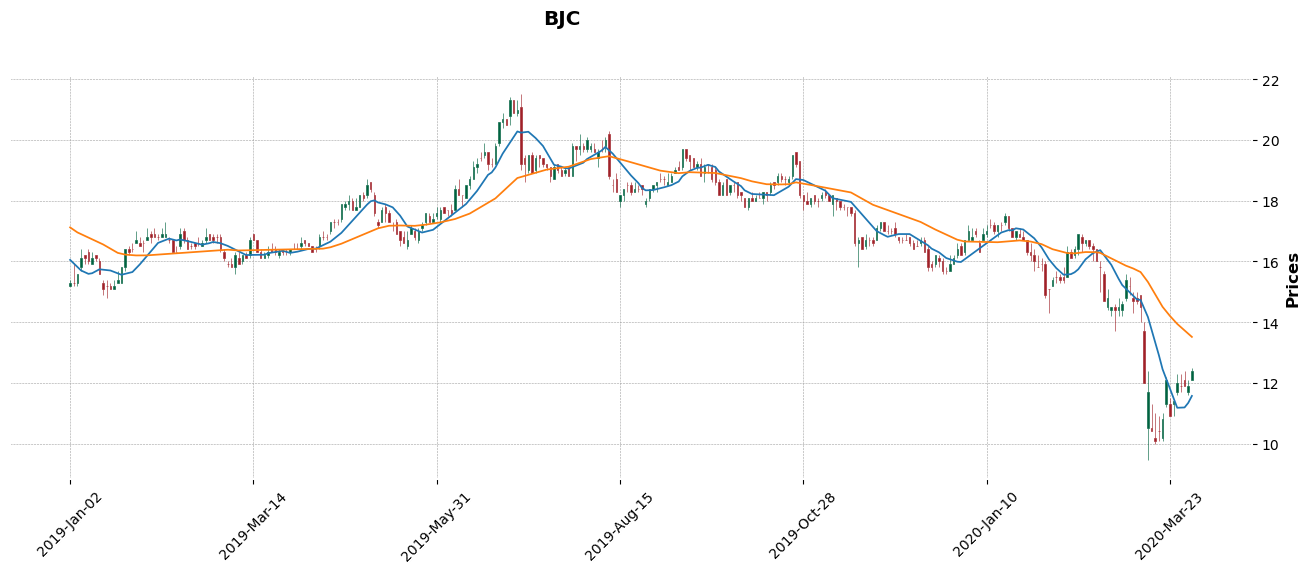

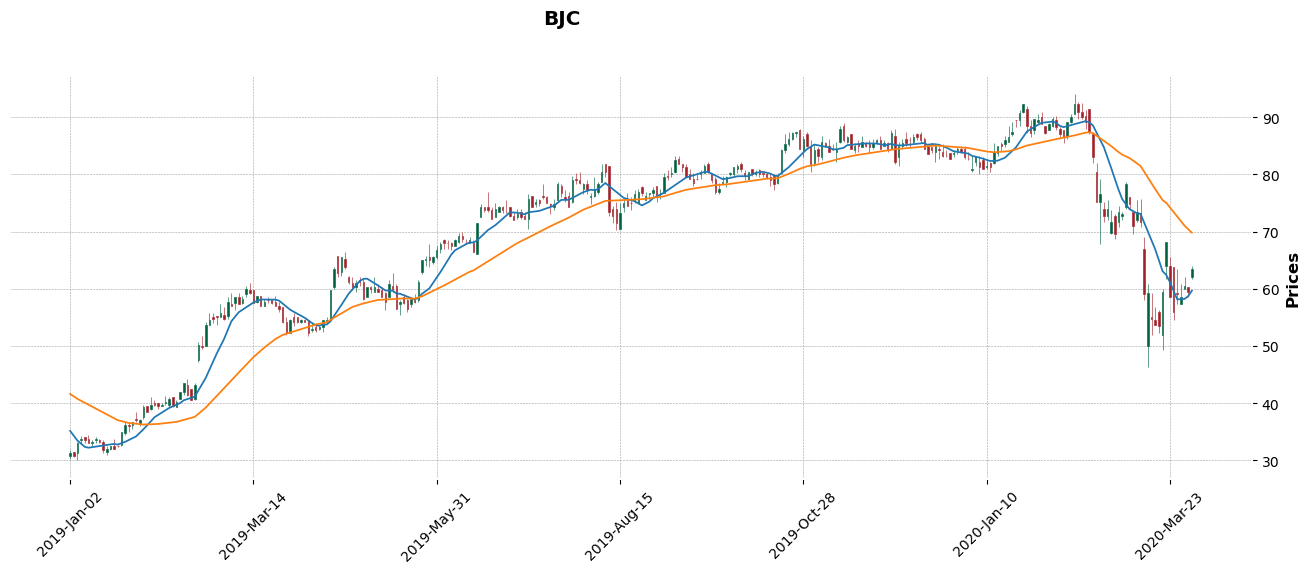

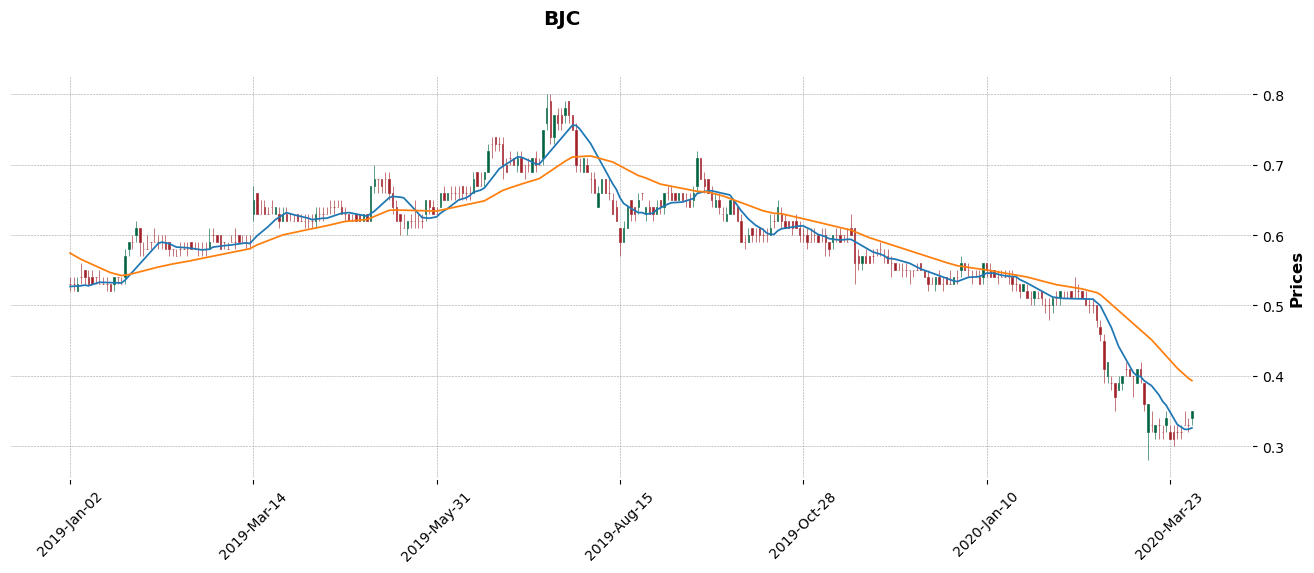

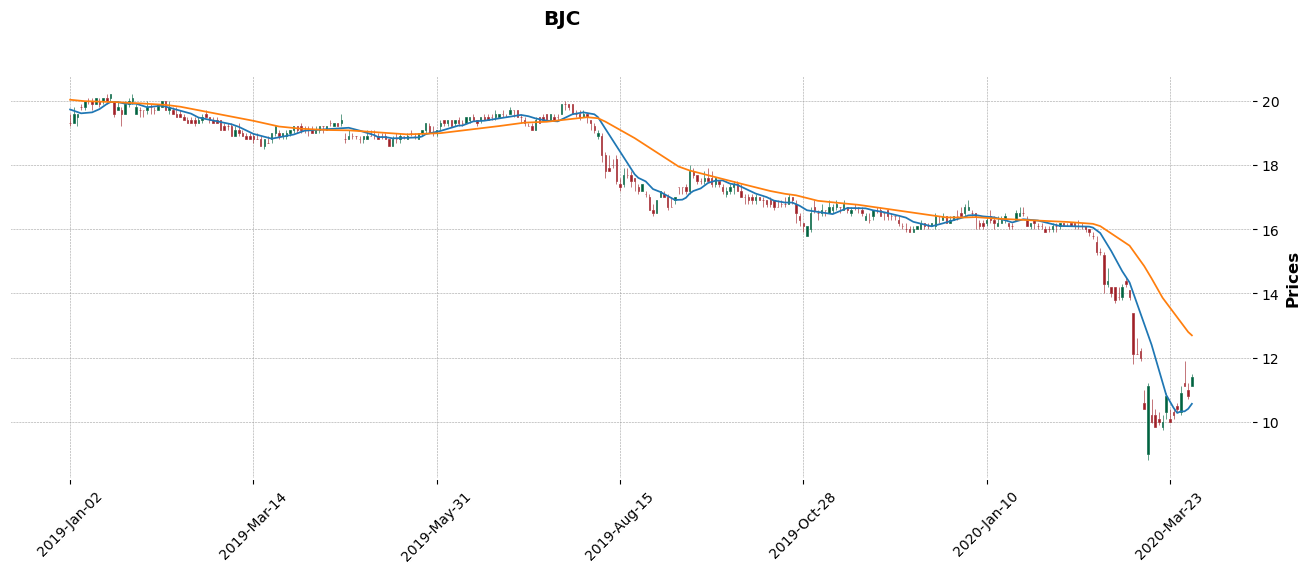

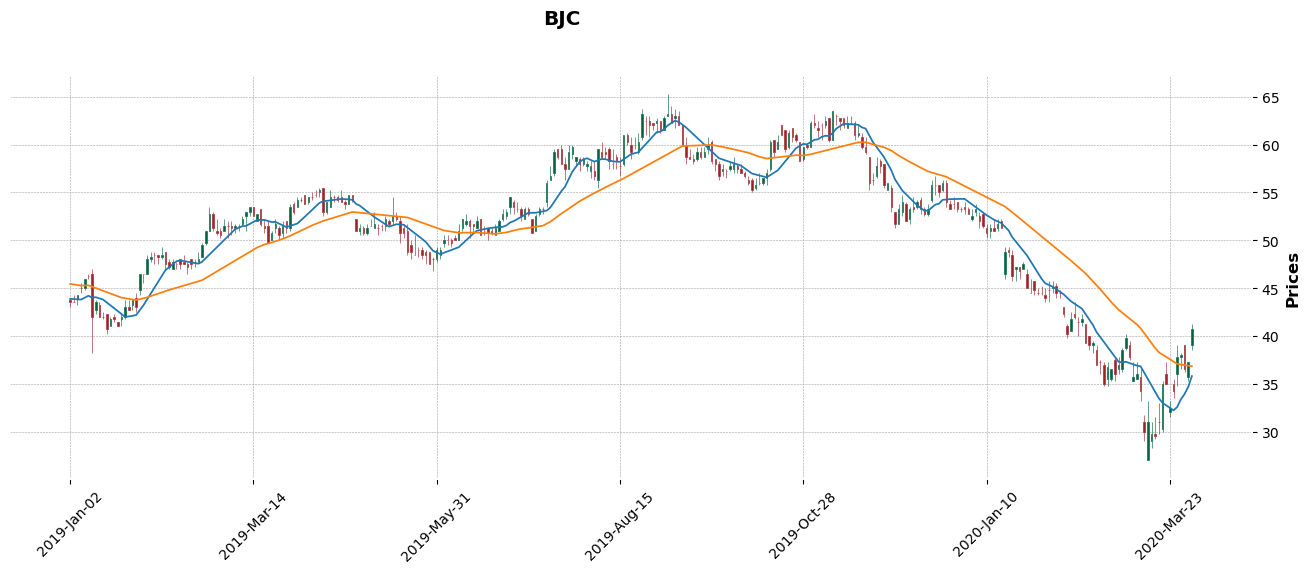

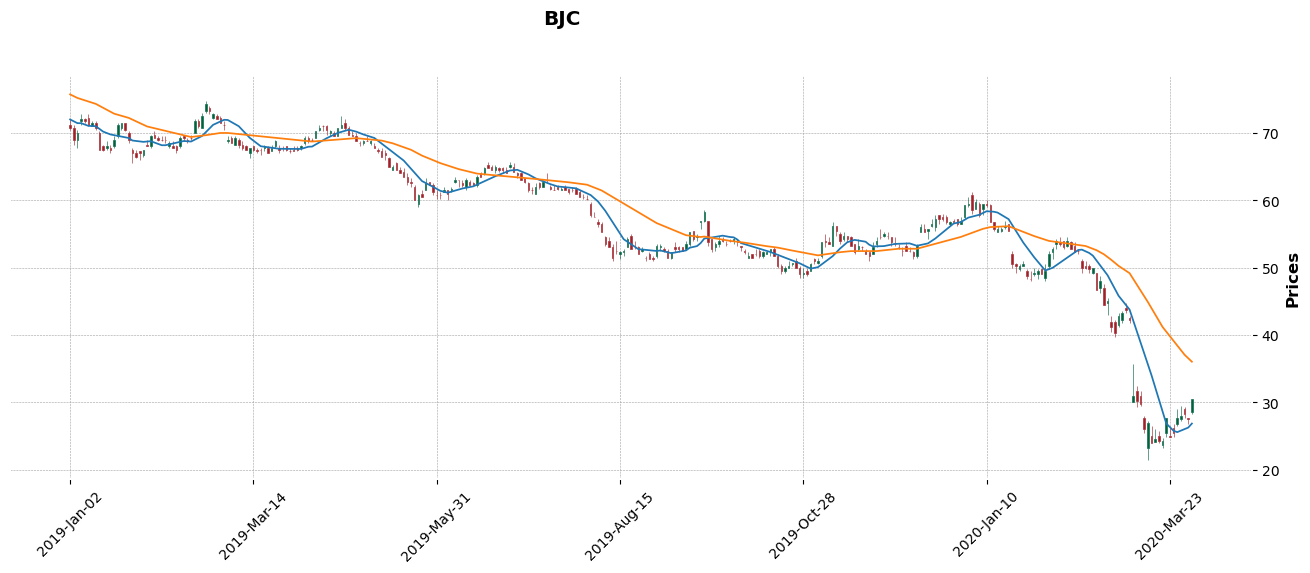

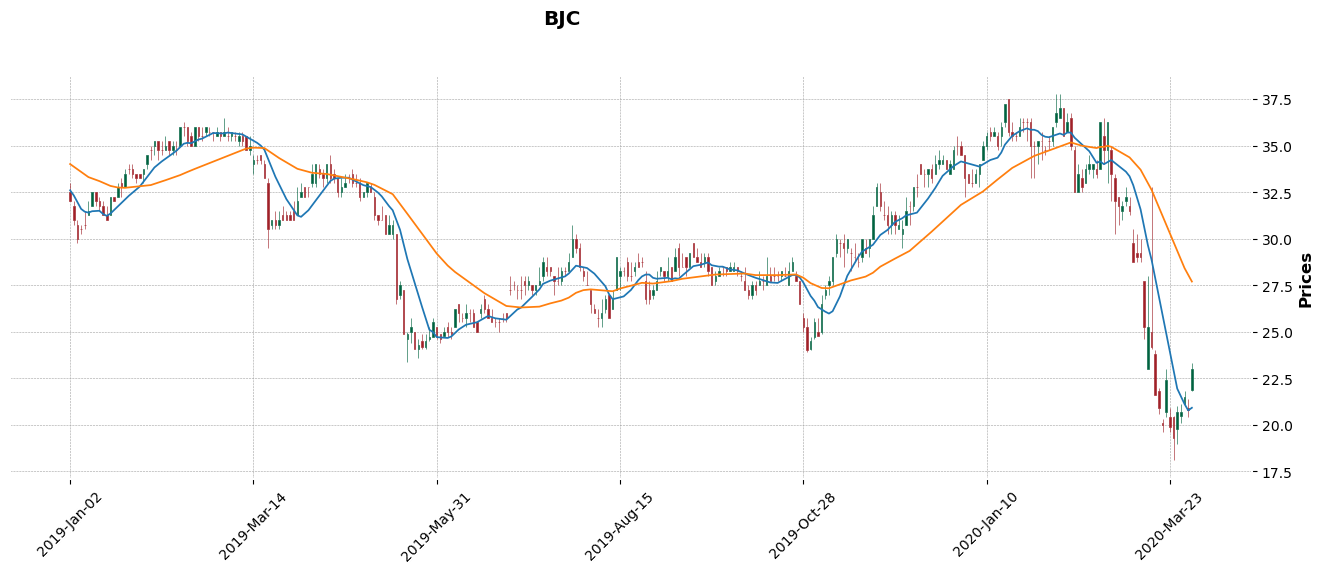

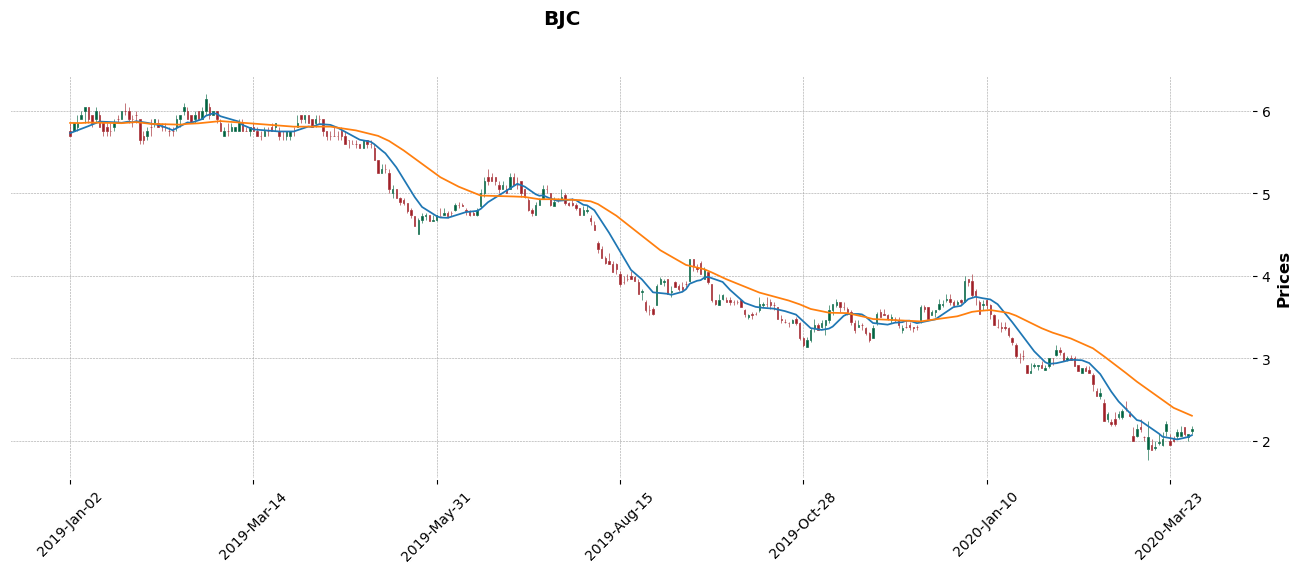

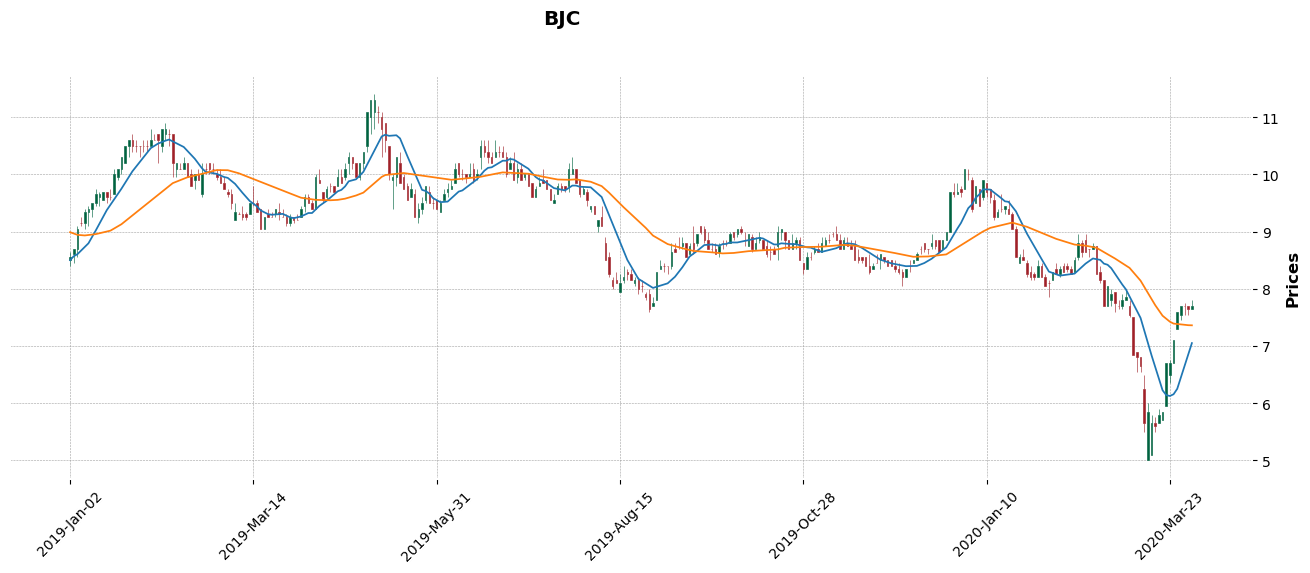

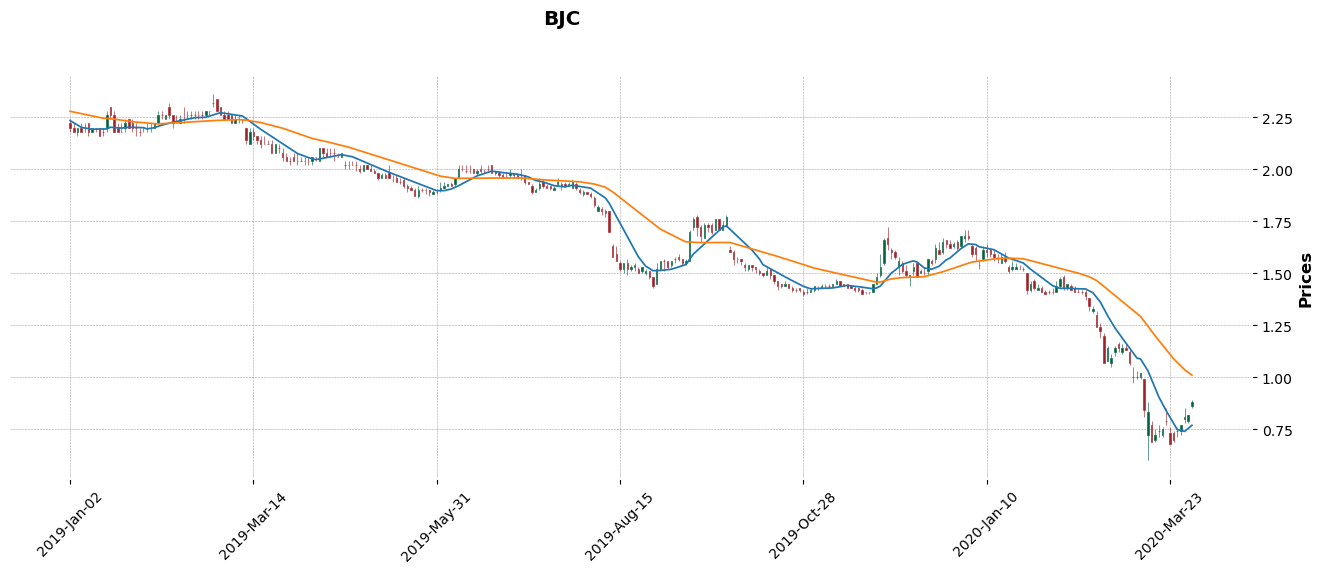

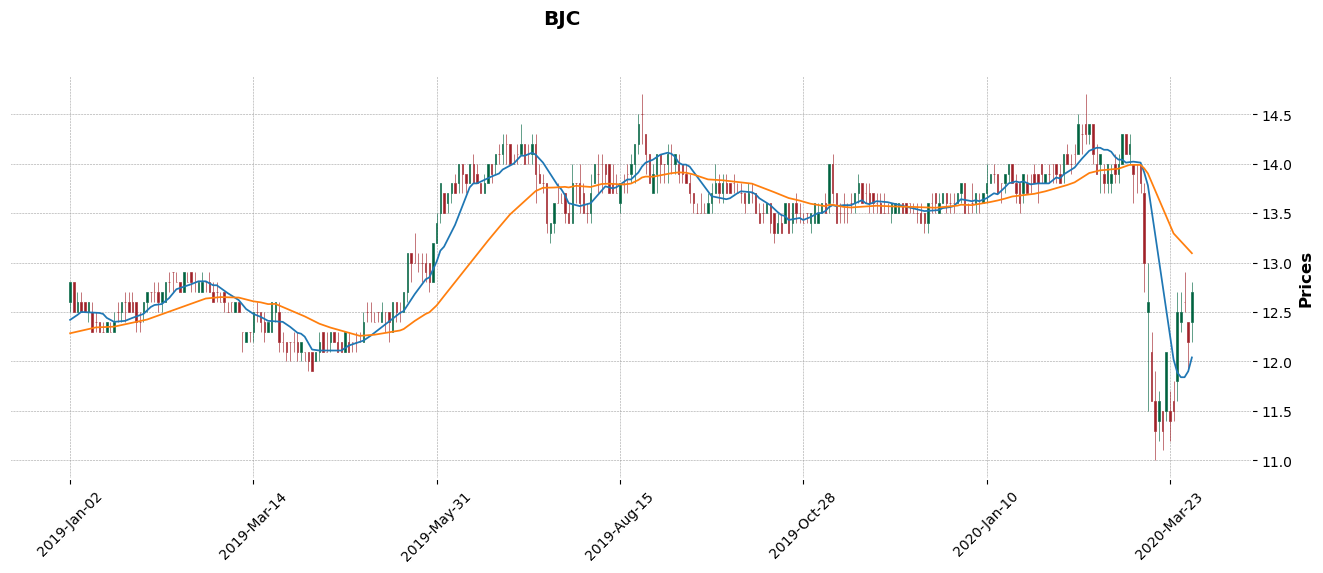

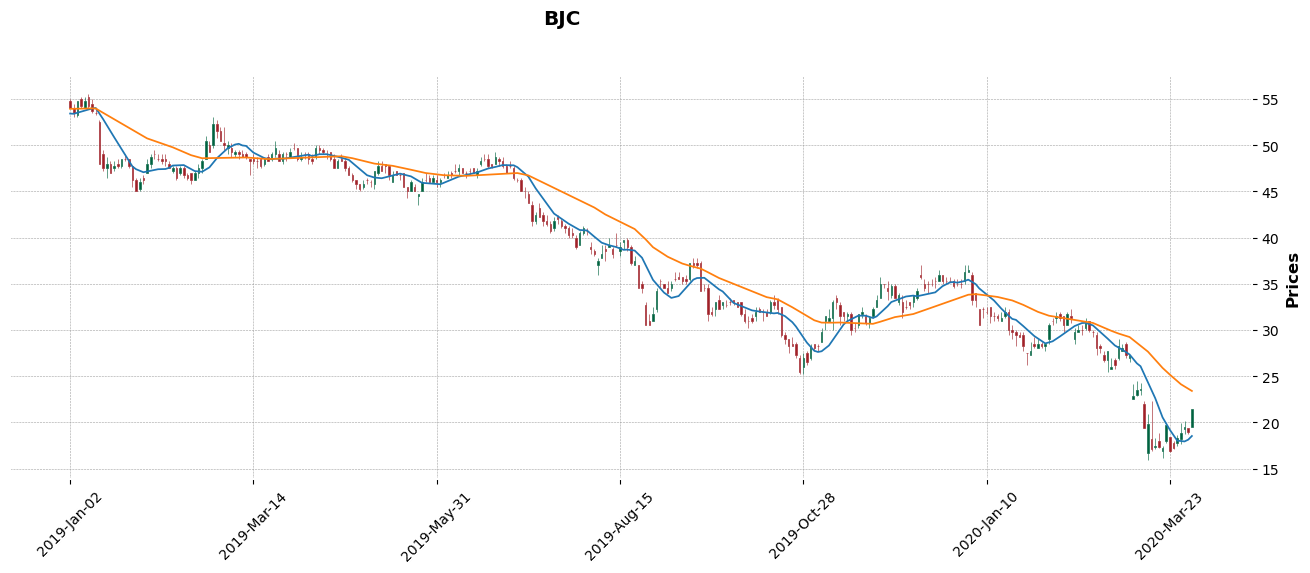

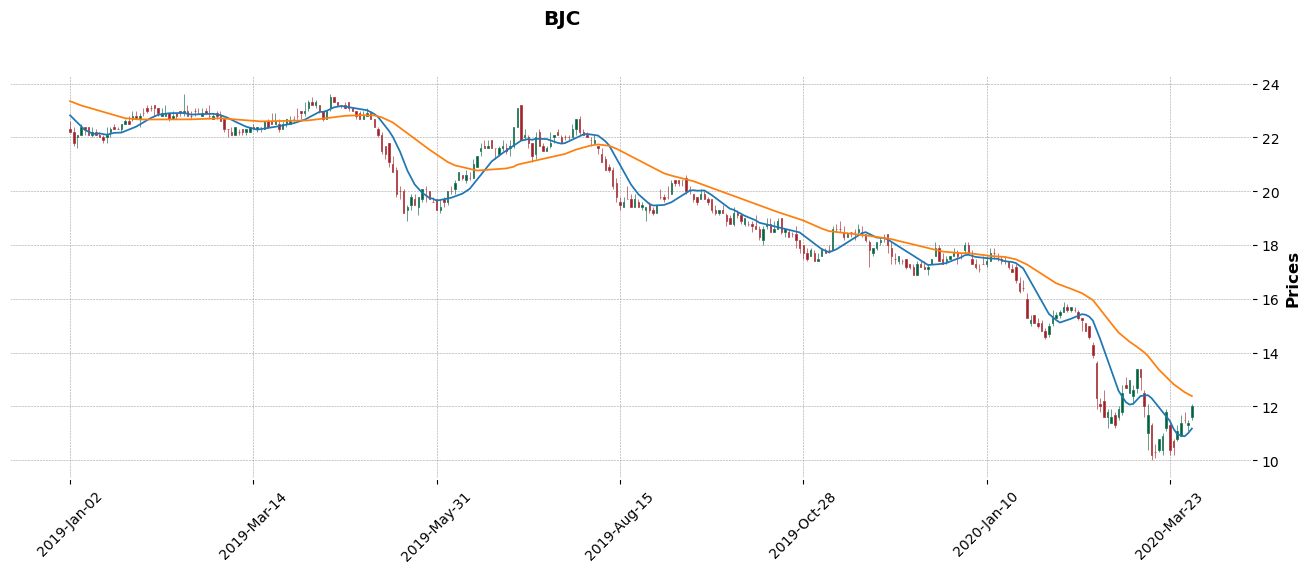

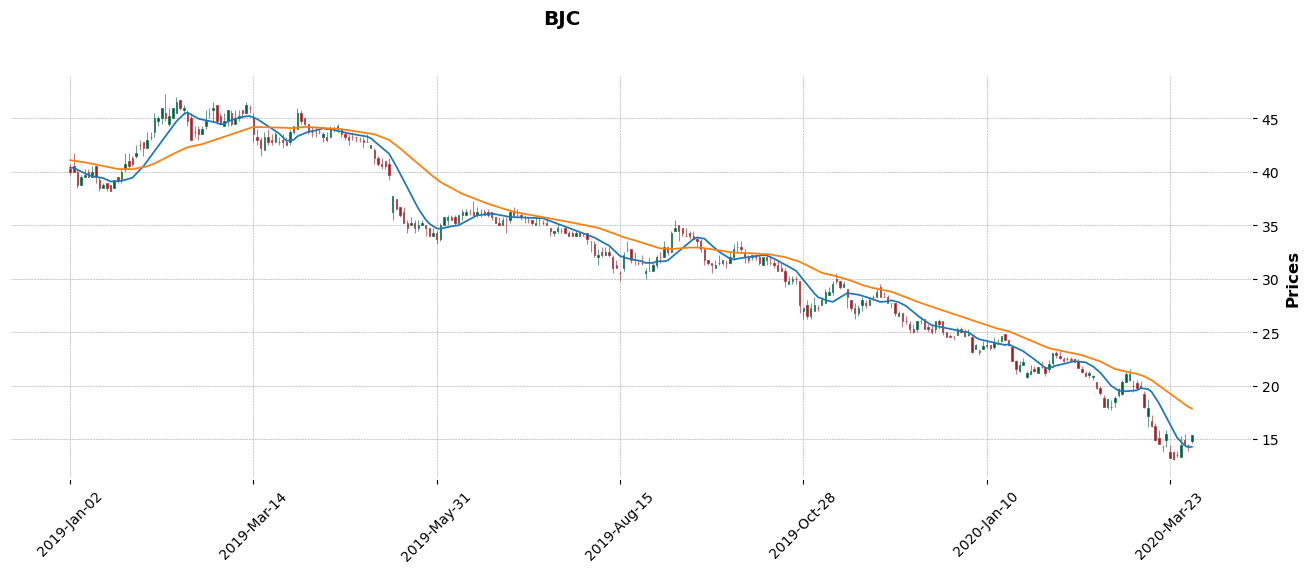

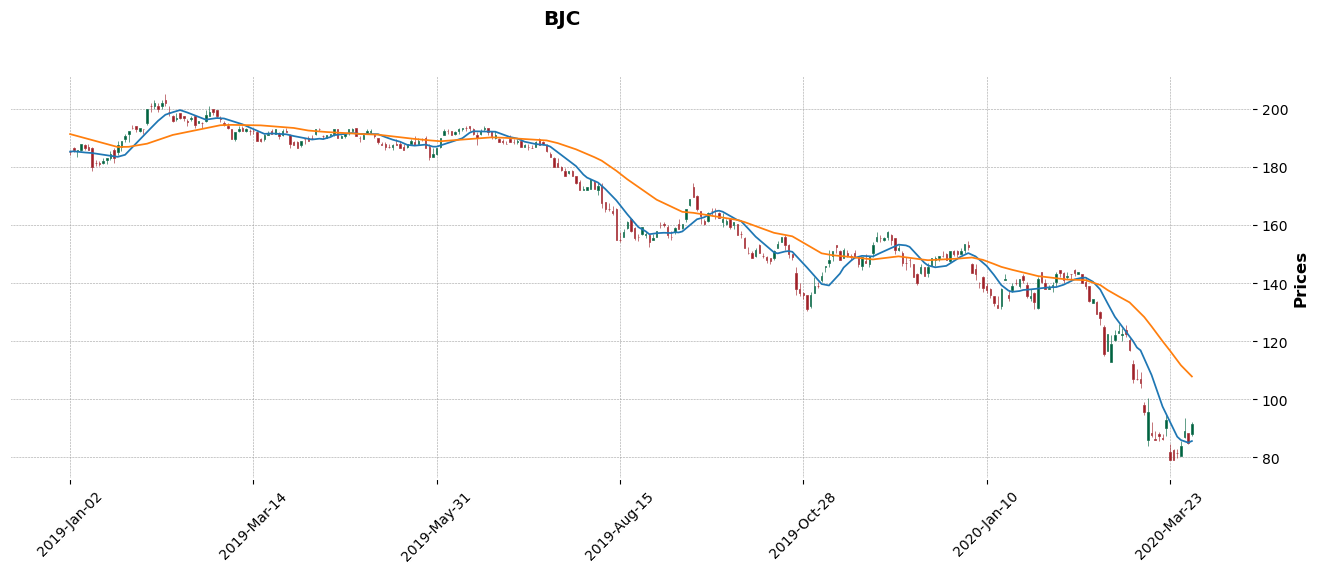

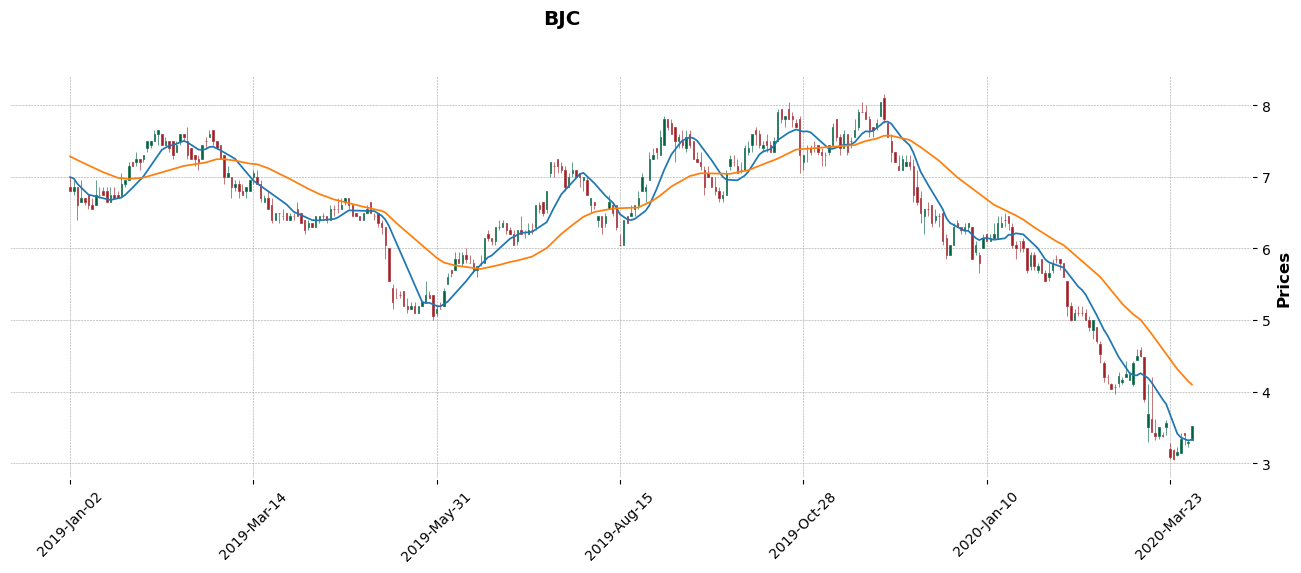

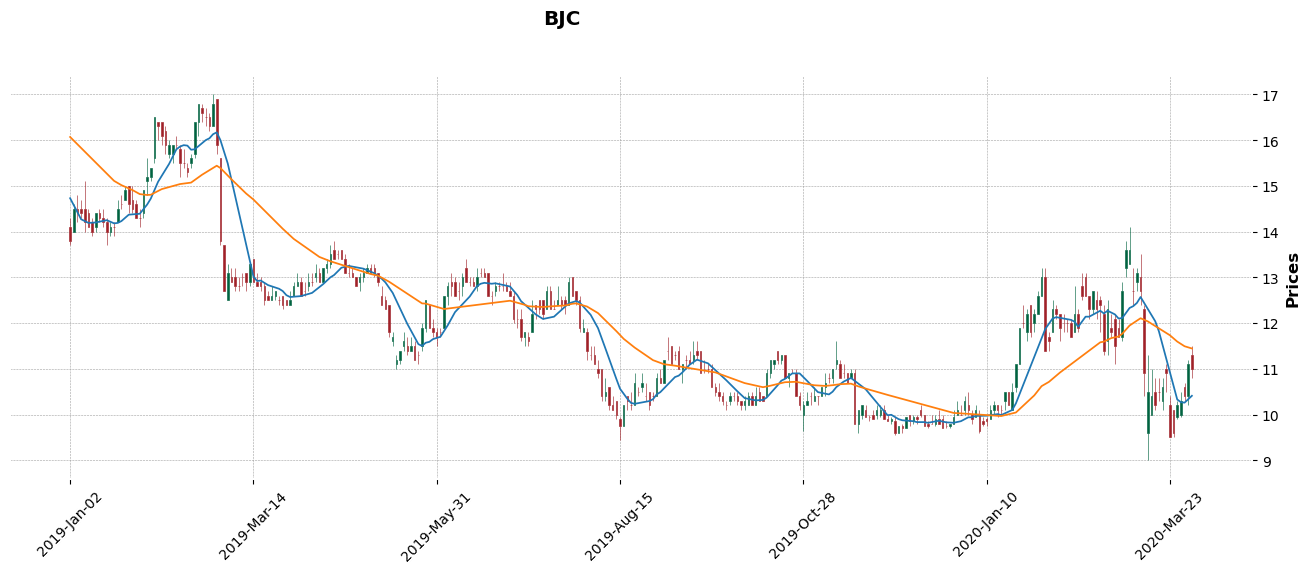

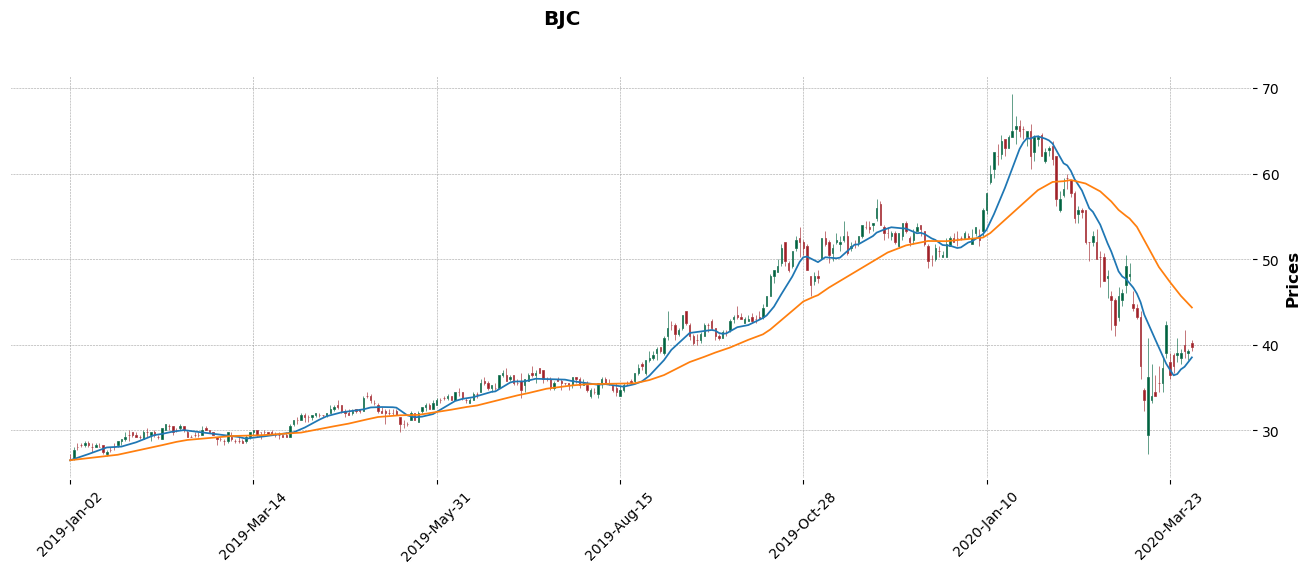

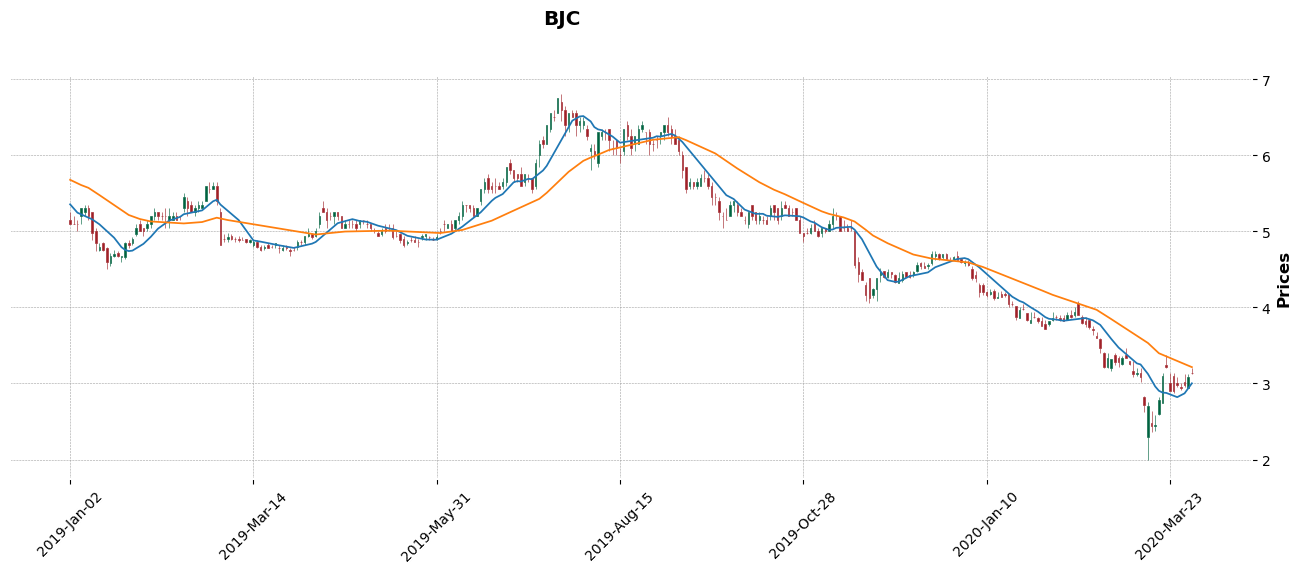

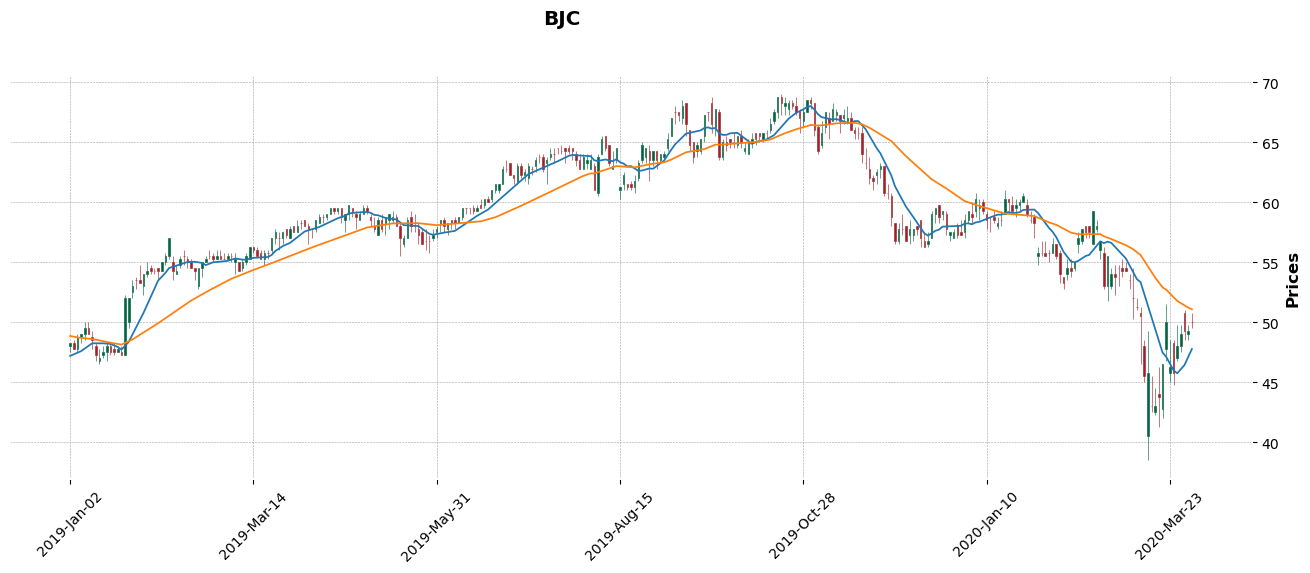

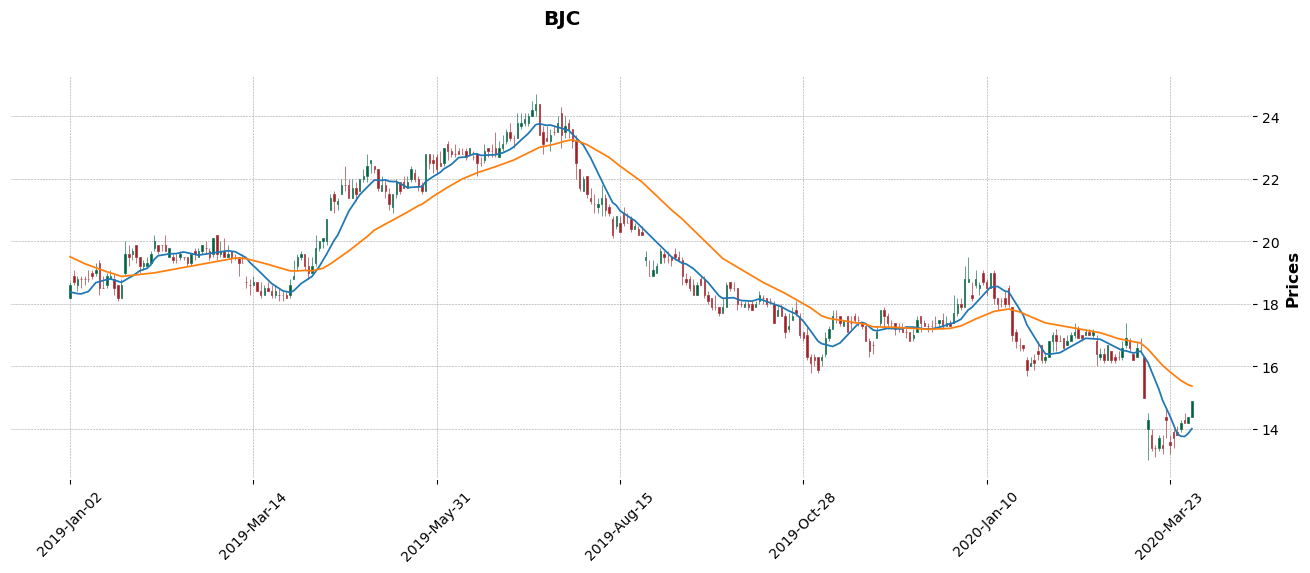

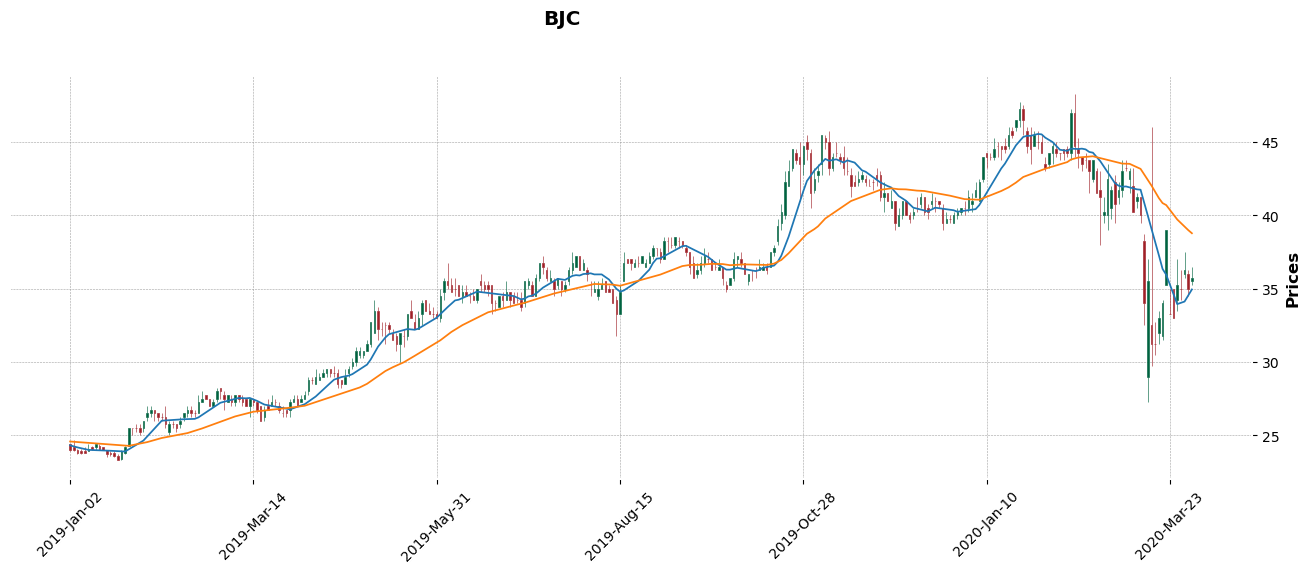

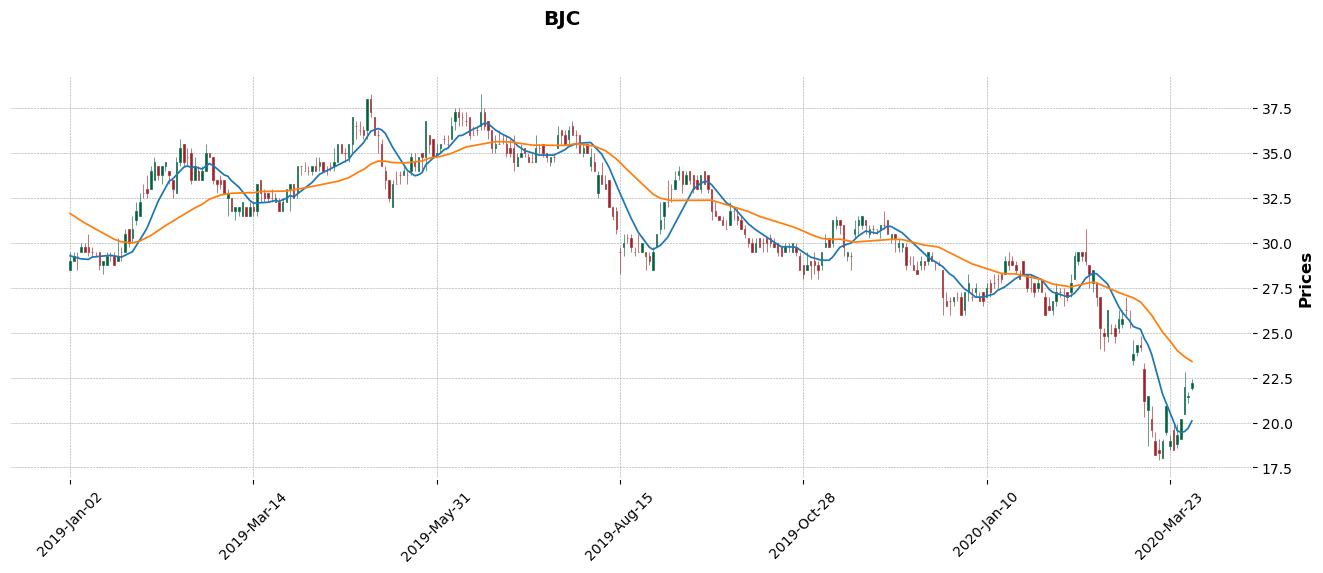

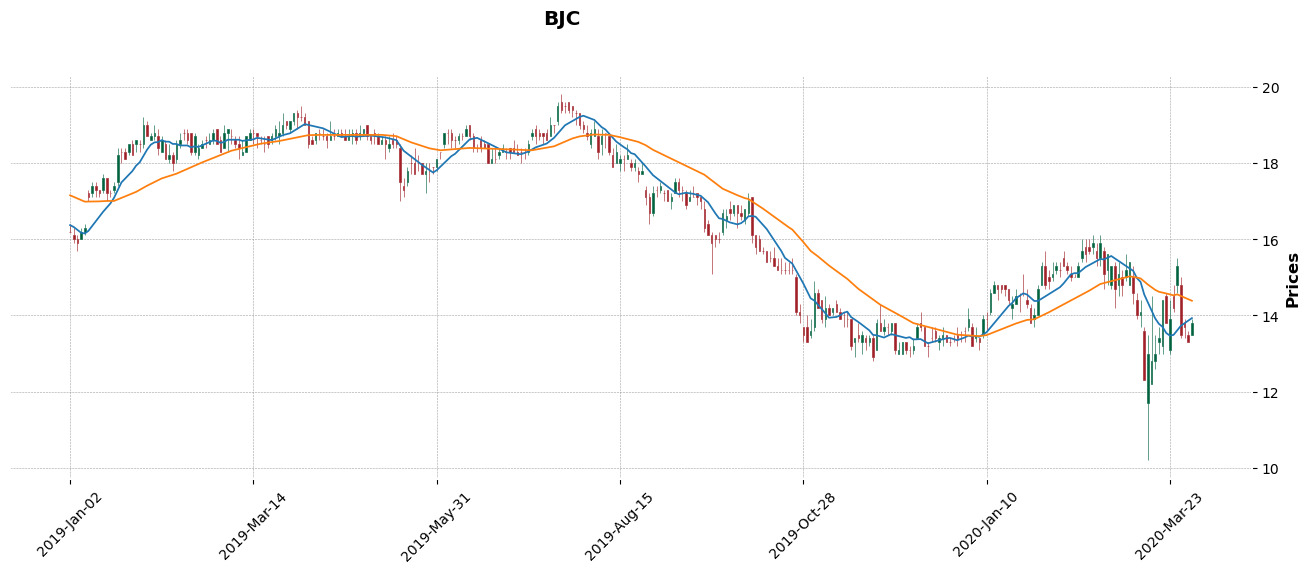

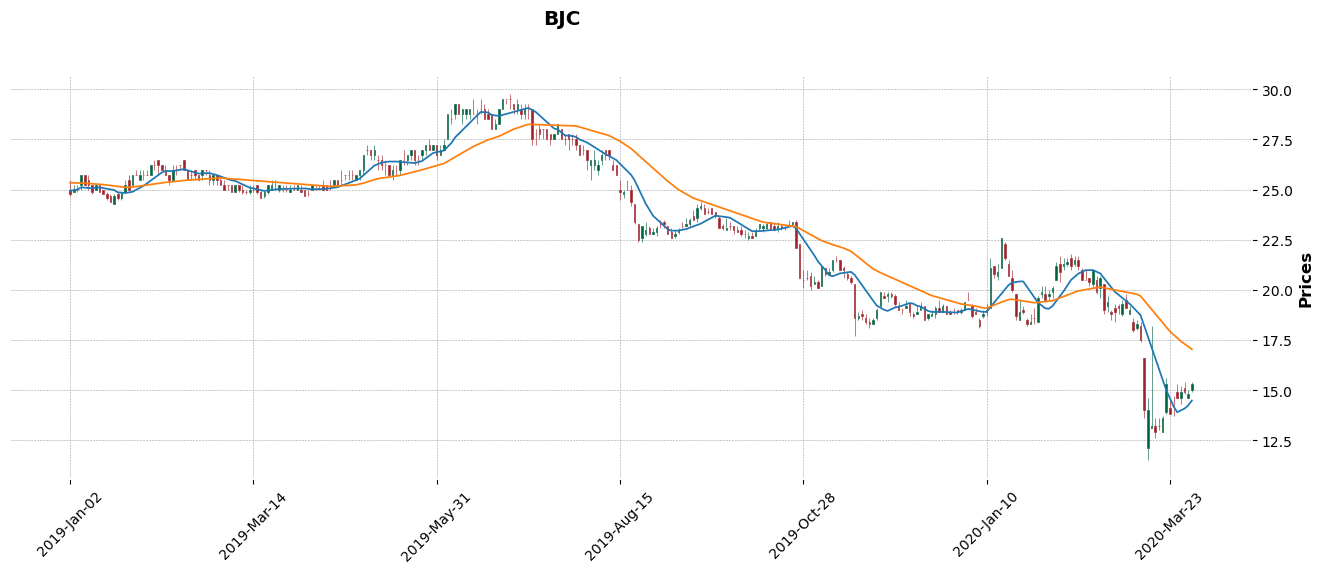

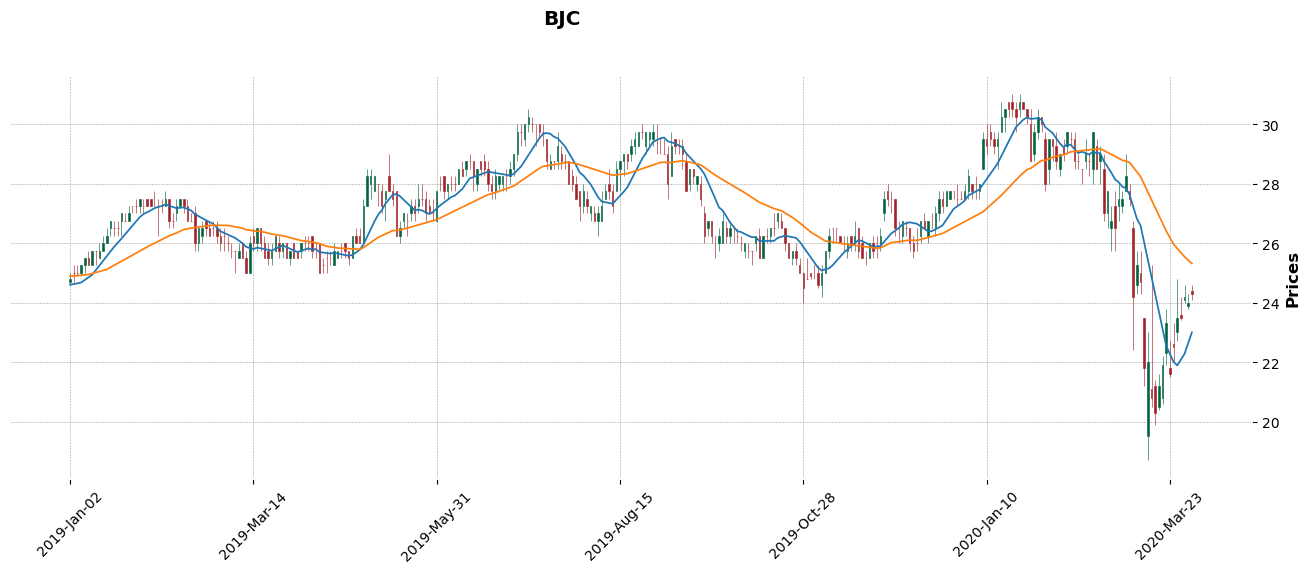

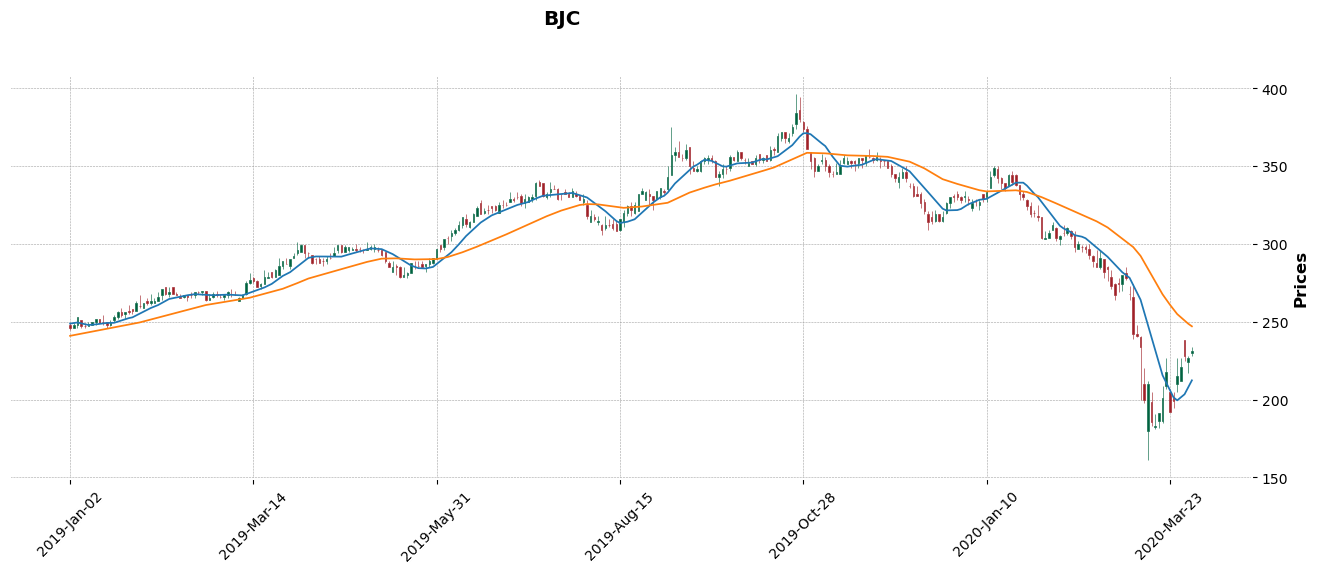

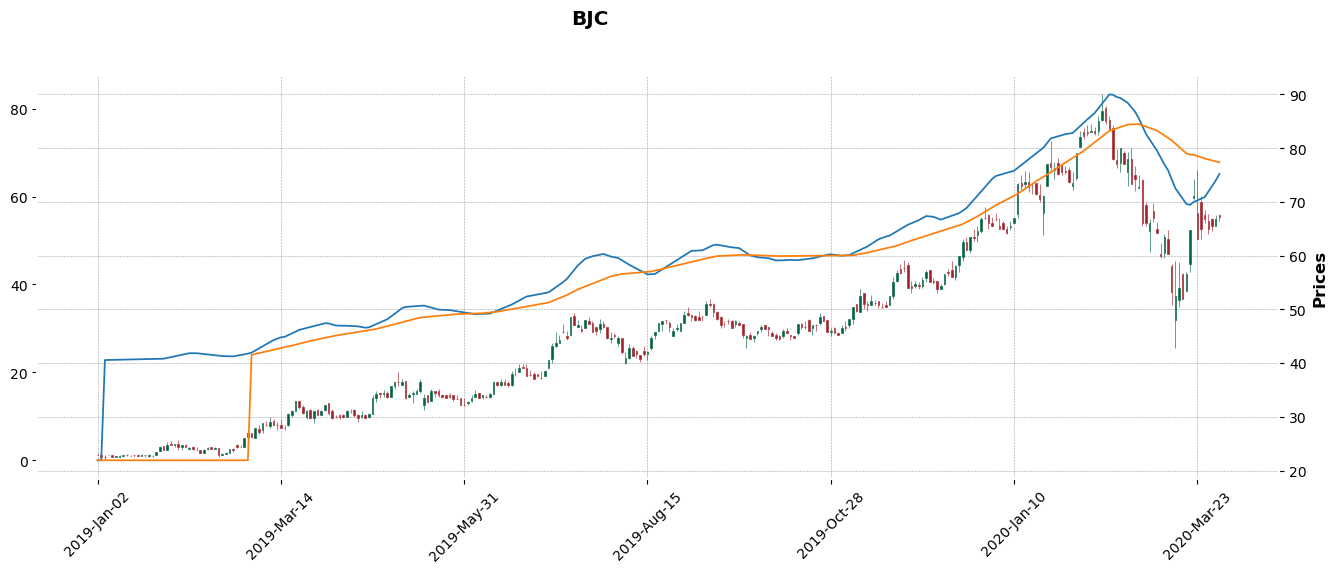

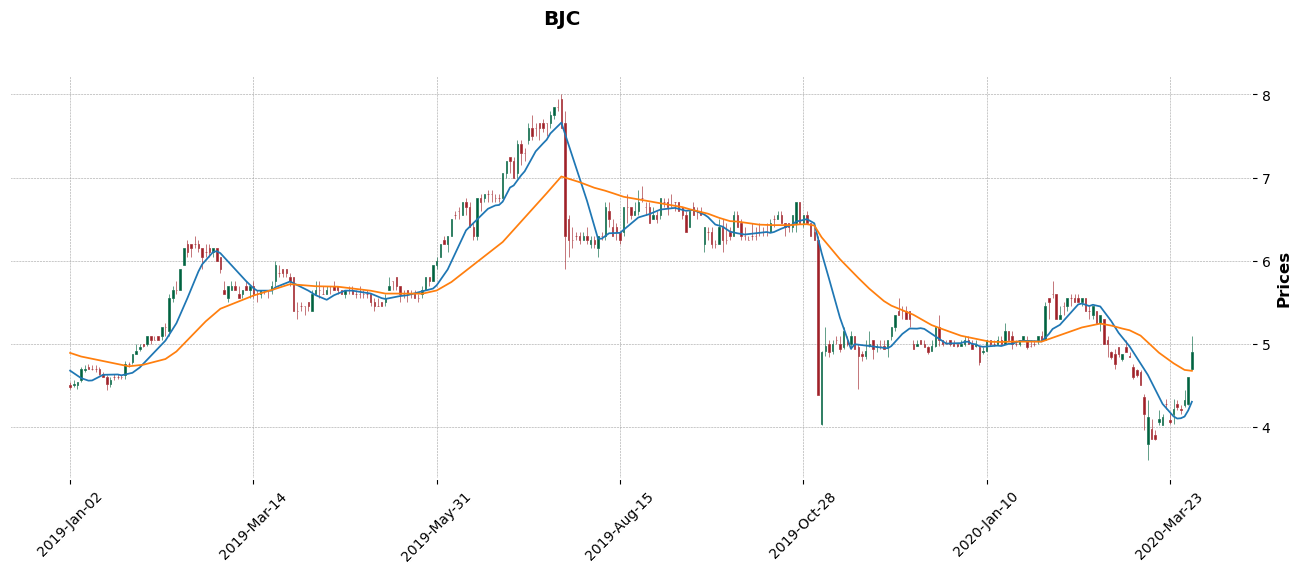

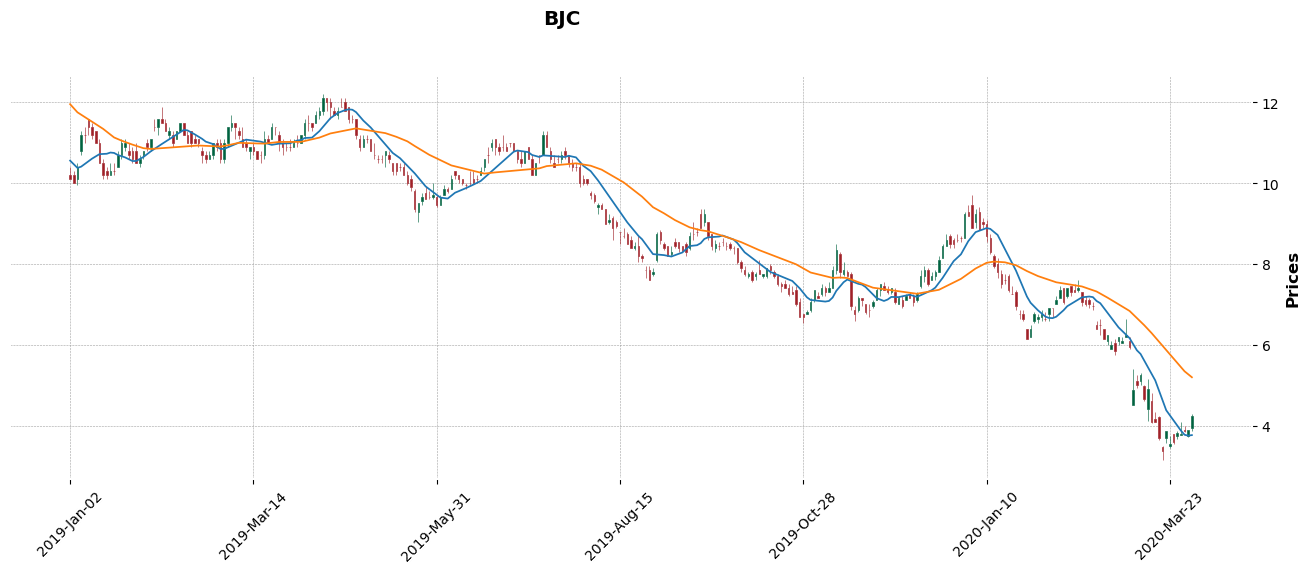

In [12]:
df_scan_ok = scanned_symbols.loc[(scanned_symbols.SCAN_RESULT == True)]

# You can specify the date range for a chart by using the 'date_start' and 'date_end' parameters
date_start = '2018-01-01' # example: 20200101 format is YYYYmmdd or 2020-01-01 format is YYYY-mm-dd
date_end = '2022-12-31' # example: 20200131 format is YYYYmmdd or 2020-01-31 format is YYYY-mm-dd
window_chart = 2000 # candles

chart_width = 30 # ระบุความกว้า่ง
chart_height = 10 # ระบุความสูง


for symbol in df_scan_ok['SYMBOL']:
    # Get sub data
    df = data_range(scanner.symbols[symbol], from_date=date_start, to_date=date_end, window=window_chart)
    new_total_rows = df.shape[0]

    df_ohlc = build_ohlc_df(df)

    # Get sub data
    df_ohlc = data_range(df_ohlc, from_date=date_start, to_date=date_end, window=window_chart)

    df_ohlc['DATETIME'] = pd.to_datetime(df_ohlc['DATETIME'], format=datetime_format)
    df_ohlc.set_index('DATETIME', inplace=True)

    #===============================================================================================

    # Plot candles chart

    apdict_ma1 = mpf.make_addplot(df['MA1'])
    apdict_ma2 = mpf.make_addplot(df['MA2'])
    plot_ohlc(df_ohlc
                      , type='candle' # type='line'
                      , style='charles'
                      , title=scanned_symbol
                      , ylabel='Prices'
                      , figratio=(chart_width, chart_height)
                      , addplot=[apdict_ma1, apdict_ma2]
                      ,)